In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import os
import glob
import seaborn as sn
import warnings
from datetime import datetime
import ncarglow as glow
import ncarglow.plots as plot
import scipy
from scipy import integrate
warnings.filterwarnings('ignore')

In [2]:
# Import training dataset
dff=pd.read_csv('WINDII_[O]_green_line(557.7 nm)_Training_dataset.csv')

In [3]:
x= dff[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
y= dff[['VER']]

x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.10,random_state=0)

In [4]:
#model= DecisionTreeRegressor(random_state = 0)
#odel =xgb.XGBRegressor(learning_rate = 0.3,max_depth = 15, n_estimators = 300)
model= RandomForestRegressor(n_estimators=60, random_state=0)
#model = MLPRegressor(random_state=35, max_iter=300)#.fit(x_train, y_train)
model.fit(x_train,y_train)

RandomForestRegressor(n_estimators=60, random_state=0)

In [5]:
# Evaluation Dataset (2001 to 2003)(Total 80 days data)
dset_evl=pd.read_csv('WINDII_[O]_green_line(557.7 nm)_Test_dataset.csv')

input_val= dset_evl[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]

output_val= dset_evl[['VER']]
rx,mtp=input_val.shape

index=range(rx)
predicted=model.predict(input_val)

In [6]:
# for train (90%) data
y_actual_train=np.array(y_train).flatten()
y_prdct_train= model.predict(x_train)     

R2_train = model.score(x_train,y_train)
R_train= np.sqrt(R2_train)

# for test (10%) data
y_actual_test=np.array(y_test).flatten()
y_prdct_test= model.predict(x_test)     

R2_test = model.score(x_test,y_test)
R_test= np.sqrt(R2_test)

# for validation data (2001-2003)
yt_actual_val=np.array(output_val).flatten()
yt_prdct_val= model.predict(input_val)     

R2_val = model.score(input_val,output_val)
R_val= np.sqrt(R2_val)

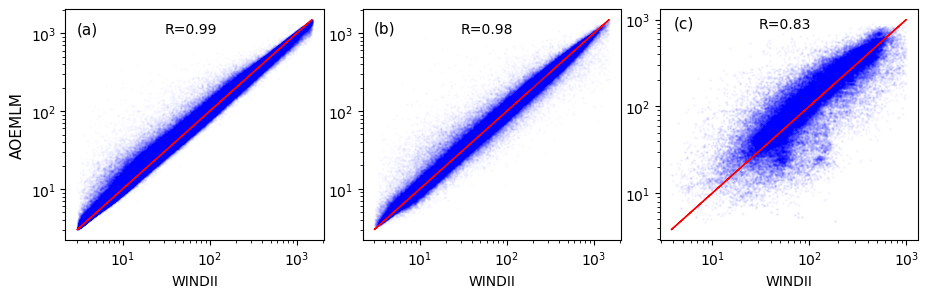

In [7]:
#***************************************************************************************************
plt.figure(figsize=(11,3))
plt.subplots_adjust(wspace=0.15)

plt.subplot(1,3,1)
plt.scatter(y_actual_train,y_prdct_train,color='blue',s=1,alpha=0.01)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('WINDII',fontsize=10)
plt.ylabel('AOEMLM',fontsize=11)
plt.text(3,1000,'(a)',fontsize=11)
plt.text(30,1000,'R=0.99',fontsize=10)

yb= R_train*y_actual_train
plt.plot(y_actual_train,yb,color='r',lw=1)
corr= np.corrcoef(y_actual_train,y_prdct_train)
#*************************************************

plt.subplot(1,3,2)
plt.scatter(y_actual_test,y_prdct_test,color='blue',s=1,alpha=0.01)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('WINDII',fontsize=10)
plt.text(3,1000,'(b)',fontsize=11)
plt.text(30,1000,'R=0.98',fontsize=10)

yb= R_test*y_actual_test
plt.plot(y_actual_test,yb,color='r',lw=1)
corr= np.corrcoef(y_actual_test,y_prdct_test)
#*************************************************

plt.subplot(1,3,3)
plt.scatter(yt_actual_val,yt_prdct_val,color='blue',s=1,alpha=0.03)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('WINDII',fontsize=10)
plt.text(4,800,'(c)',fontsize=11)
plt.text(30,800,'R=0.83',fontsize=10)

yb= 1*yt_actual_val
plt.plot(yt_actual_val,yb,color='r',lw=1) # y=x line
corr= np.corrcoef(yt_actual_val,yt_prdct_val)

#plt.savefig('train_test_valid.png', format='png', dpi=300,bbox_inches='tight')

In [8]:
# Daily averaged VER 2001-2003

In [9]:
lim=[]

for i in range(2001,2004):
    dfa=dset_evl[(dset_evl['YEAR']==i)]
    dy=dfa['DOY_x'].unique()
    
    for j in range(len(dy)):
        dfx=dfa[(dfa['DOY_x']==dy[j])]
        input_test= dfx[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
        mver=model.predict(input_test)
        dfx.insert(21,'mVER',mver)
        df0=pd.DataFrame(dfx.mean()).T
        lim.append(df0)
        
dfn=pd.concat(lim)
dfn.insert(3,'Index',range(80))

In [10]:
dfg=pd.read_csv('GLOW_WINDII_daily_averaged_VER_2001_2003.csv') # GLOW estimated Intensity dataset

Mean deviation AOEMLM= 14.942864088482915
Mean deviation GLOW= 28.435969341463085


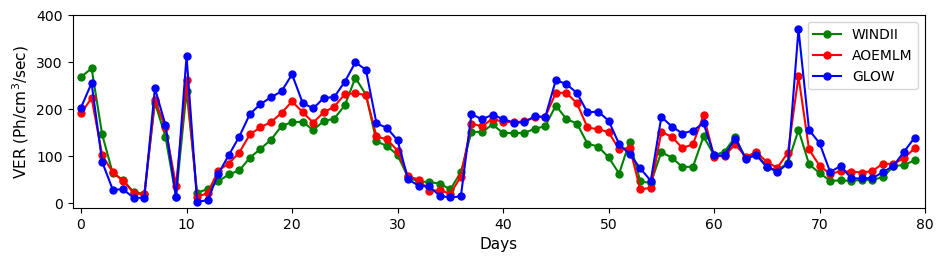

In [11]:
plt.figure(figsize=(11,2.5))

plt.xlabel('Days',fontsize=11)
plt.ylabel('VER (Ph/cm$^3$/sec)',fontsize=11)
plt.xlim(-0.8,80)
plt.ylim(-10,400)
#dt=dfn['YEAR']+dfn['DOY_x']/365
plt.plot(dfn['Index'],dfn['VER'],c='g',label='WINDII',marker='o',markersize=5)
plt.plot(dfn['Index'],dfn['mVER'],c='r',label='AOEMLM',marker='o',markersize=5)
plt.plot(dfg['Index'],dfg['GLOW'],c='b',label='GLOW',marker='o',markersize=5)

plt.legend()

diffr=(dfn['mVER']-dfn['VER'])
mean_deviation_val= sum(diffr)/len(diffr)
print('Mean deviation AOEMLM=', mean_deviation_val)

diffrg=(dfg['GLOW']-dfg['VER'])
mean_deviation_valg= sum(diffrg)/len(diffrg)
print('Mean deviation GLOW=', mean_deviation_valg)

#plt.savefig('Daily_average_VER_2001_2003.png', dpi=300,bbox_inches='tight')
#plt.savefig('Daily_average_VER_2001_2003.eps', dpi=300,bbox_inches='tight')

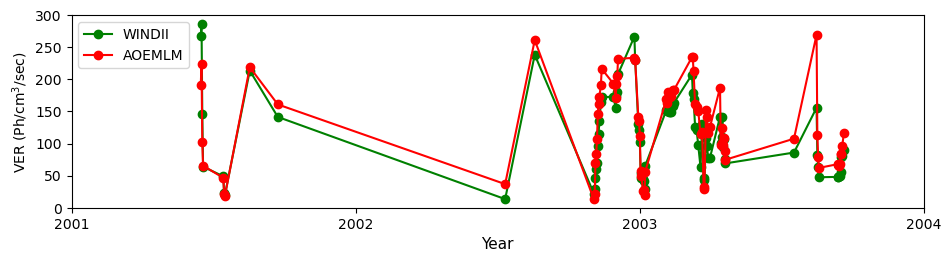

In [12]:
plt.figure(figsize=(11,2.5))

plt.xlabel('Year',fontsize=11)
plt.ylabel('VER (Ph/cm$^3$/sec)',fontsize=10)
plt.xlim(2001,2004)
xtk=np.arange(2001,2005,1)
plt.xticks(xtk)
plt.ylim(0,300)
dt=dfn['YEAR']+dfn['DOY_x']/365
#x=range(80)
plt.plot(dt,dfn['VER'],c='g',label='WINDII',marker='o')
plt.plot(dt,dfn['mVER'],c='r',label='AOEMLM',marker='o')
plt.legend()

#plt.savefig('YYYY_Daily_average_VER_2001_2003.png', dpi=300,bbox_inches='tight')
#plt.savefig('Y_Daily_average_VER_2001_2003.eps', dpi=300,bbox_inches='tight')

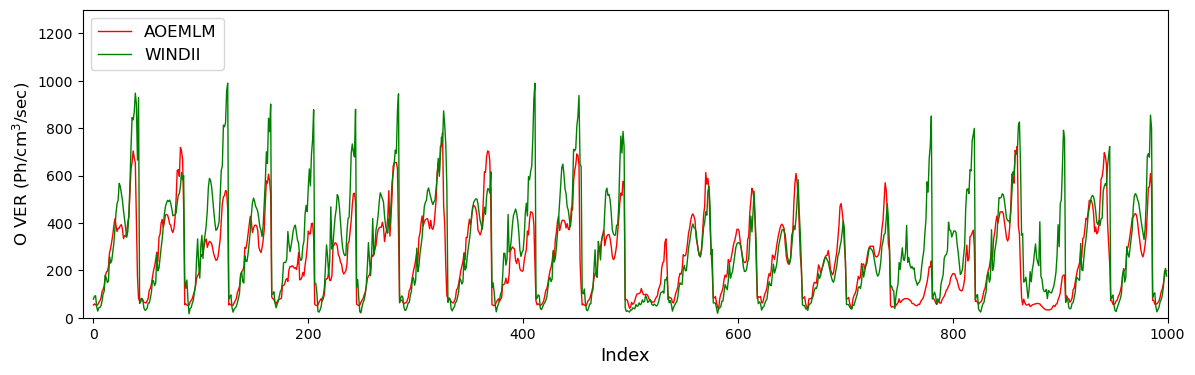

In [13]:
input_test= dset_evl[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
output_test= dset_evl[['VER']]
rx,mtp=input_test.shape
index=range(rx)
predicted=model.predict(input_test)

plt.figure(figsize=(14,4))
plt.ylim(0,1300)
plt.xlim(-10,1000)
plt.xlabel('Index',fontsize=13)
plt.ylabel('O VER (Ph/cm$^3$/sec)',fontsize=12)
plt.plot(index,predicted,color='red',linewidth=1,label='AOEMLM')
plt.plot(index,output_test['VER'],color='green',linewidth=1,label='WINDII')
plt.legend(loc=('upper left'),fontsize=12)
#plt.savefig('test_sample_n.png',dpi=800, bbox_inches='tight')
#plt.savefig('test_sample_n.eps',dpi=800, bbox_inches='tight')

In [14]:
#Test samples

In [15]:
dset_evl=pd.read_csv('Test_profile_dataset.csv')

In [16]:
# **************March Lower, Higher latitudes

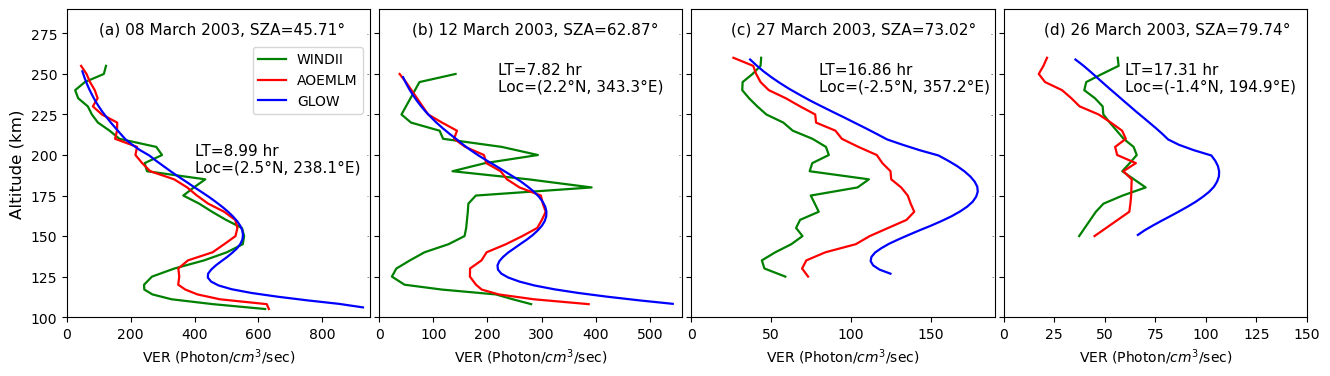

In [17]:
v1=dset_evl[(dset_evl['latitude']==2.5) & (dset_evl['longitude']==238.1) & (dset_evl['SZA']==45.71)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)
plt.subplot(1,4,1)
plt.xlim(0,950)
plt.ylim(100,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(100,275,'(a) 08 March 2003, SZA=45.71\N{DEGREE SIGN}',fontsize=11)
#plt.text(100,90,'LT=8.99 hr, Loc=(2.5\N{DEGREE SIGN}N, 238.1\N{DEGREE SIGN}E)',fontsize=11)
plt.text(400,200,'LT=8.99 hr',fontsize=11)
plt.text(400,190,'Loc=(2.5\N{DEGREE SIGN}N, 238.1\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 8, 17, 18, 0)
glat = 2.5
glon = 238.1-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==2.2) & (dset_evl['longitude']==343.3) & (dset_evl['SZA']==62.87)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
plt.xlim(0,560)
plt.ylim(100,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(60,275,'(b) 12 March 2003, SZA=62.87\N{DEGREE SIGN}',fontsize=11)
#plt.text(50,90,'LT=7.82 hr, Loc=(2.2\N{DEGREE SIGN}N, 343.3\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(220,250,'LT=7.82 hr',fontsize=11)
plt.text(220,240,'Loc=(2.2\N{DEGREE SIGN}N, 343.3\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 12, 9, 6, 0)
glat = 2.2
glon = 343.3-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==-2.5) & (dset_evl['longitude']==357.2) & (dset_evl['SZA']==73.02)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,4,3)
plt.xlim(0,190)
plt.ylim(100,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(25,275,'(c) 27 March 2003, SZA=73.02\N{DEGREE SIGN}',fontsize=11)
#plt.text(15,90,'LT=16.86 hr, Loc=(-2.5\N{DEGREE SIGN}N, 357.2\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(80,250,'LT=16.86 hr',fontsize=11)
plt.text(80,240,'Loc=(-2.5\N{DEGREE SIGN}N, 357.2\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 27, 17, 8, 0)
glat = -2.5
glon = 357.2-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==-1.4) & (dset_evl['longitude']==194.9) & (dset_evl['SZA']==79.74)].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']

plt.subplot(1,4,4)
plt.xlim(0,150)
plt.ylim(100,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(20,275,'(d) 26 March 2003, SZA=79.74\N{DEGREE SIGN}',fontsize=11)
#plt.text(12,90,'LT=17.31 hr, Loc=(-1.4\N{DEGREE SIGN}N, 194.9\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(60,250,'LT=17.31 hr',fontsize=11)
plt.text(60,240,'Loc=(-1.4\N{DEGREE SIGN}N, 194.9\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 26, 4, 25, 0)
glat = -1.4
glon = 194.9-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('March_L.png', dpi=800, bbox_inches='tight')
#plt.savefig('March_L.eps', dpi=800, bbox_inches='tight')

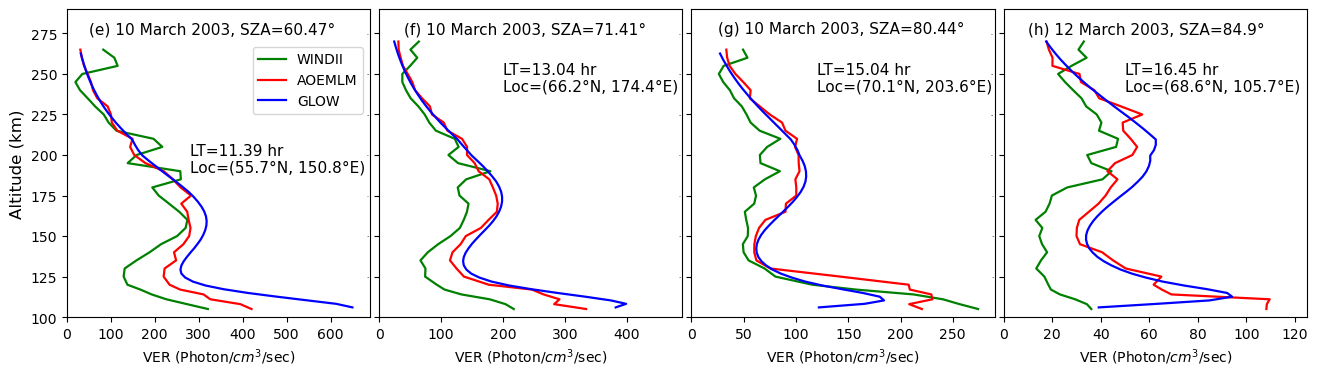

In [18]:
v1=dset_evl[(dset_evl['latitude']==55.7) & (dset_evl['longitude']==150.8) & (dset_evl['SZA']==60.47)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)
plt.subplot(1,4,1)
plt.xlim(0,690)
plt.ylim(100,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(50,275,'(e) 10 March 2003, SZA=60.47\N{DEGREE SIGN}',fontsize=11)                    
#plt.text(45,90,'LT=11.39 hr, Loc=(55.7\N{DEGREE SIGN}N, 150.8\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(280,200,'LT=11.39 hr',fontsize=11)
plt.text(280,190,'Loc=(55.7\N{DEGREE SIGN}N, 150.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 10, 1, 30, 0)
glat = 55.7
glon = 150.8
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==66.2) & (dset_evl['longitude']==174.4) & (dset_evl['SZA']==71.41)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']

plt.subplot(1,4,2)
plt.xlim(0,490)
plt.ylim(100,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(40,275,'(f) 10 March 2003, SZA=71.41\N{DEGREE SIGN}',fontsize=11)
#plt.text(35,90,'LT=13.04 hr, Loc=(66.2\N{DEGREE SIGN}N, 174.4\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(200,250,'LT=13.04 hr',fontsize=11)
plt.text(200,240,'Loc=(66.2\N{DEGREE SIGN}N, 174.4\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 10, 1, 36, 0)
glat = 66.2
glon = 174.4
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==70.1) & (dset_evl['longitude']==203.6) & (dset_evl['SZA']==80.44)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']

plt.subplot(1,4,3)
plt.xlim(0,290)
plt.ylim(100,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(25,275,'(g) 10 March 2003, SZA=80.44\N{DEGREE SIGN}',fontsize=11)
#plt.text(23,90,'LT=15.04 hr, Loc=(70.1\N{DEGREE SIGN}N, 203.6\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(120,250,'LT=15.04 hr',fontsize=11)
plt.text(120,240,'Loc=(70.1\N{DEGREE SIGN}N, 203.6\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 10, 1, 38, 0)
glat = 70.1
glon = 203.6-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==68.6) & (dset_evl['longitude']== 105.7) & (dset_evl['SZA']==84.9)]
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']

plt.subplot(1,4,4)
plt.xlim(0,125)
plt.ylim(100,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,275,'(h) 12 March 2003, SZA=84.9\N{DEGREE SIGN}',fontsize=11)
#plt.text(10,90,'LT=16.45 hr, Loc=(68.6\N{DEGREE SIGN}N, 105.7\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(50,250,'LT=16.45 hr',fontsize=11)
plt.text(50,240,'Loc=(68.6\N{DEGREE SIGN}N, 105.7\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 3, 12, 9, 34, 0)
glat = 68.6
glon = 105.7
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('March_H.png', dpi=800, bbox_inches='tight')
#plt.savefig('March_H.eps', dpi=800, bbox_inches='tight')

In [19]:
#***********September

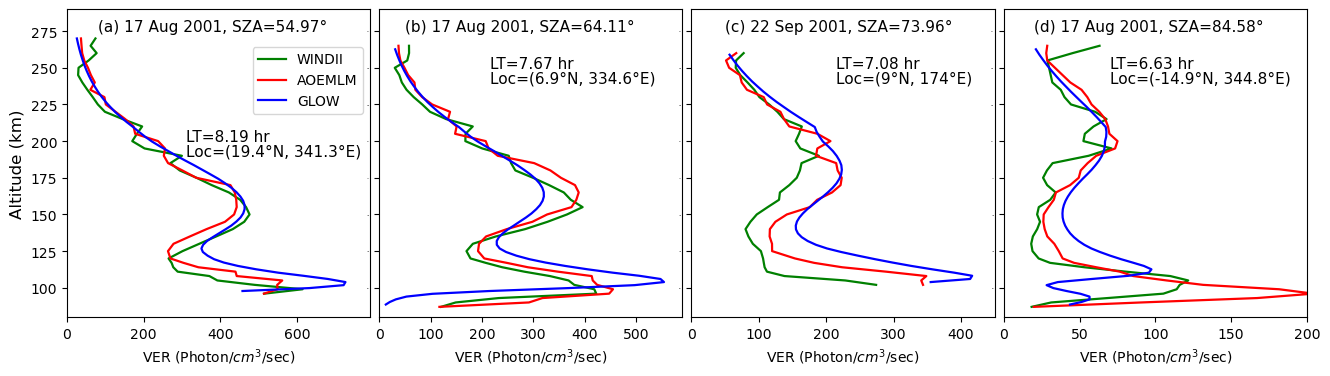

In [20]:
v1=dset_evl[(dset_evl['latitude']==19.4) & (dset_evl['longitude']==341.3) & (dset_evl['SZA']==54.97)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)

plt.subplot(1,4,1)
plt.xlim(0,790)
plt.ylim(80,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(80,275,'(a) 17 Aug 2001, SZA=54.97\N{DEGREE SIGN}',fontsize=11)         
#plt.text(65,80,'LT=8.19 hr, Loc=(19.4\N{DEGREE SIGN}N, 341.3\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(310,200,'LT=8.19 hr',fontsize=11)
plt.text(310,190,'Loc=(19.4\N{DEGREE SIGN}N, 341.3\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2001, 8, 17, 9, 30, 0)
glat = 19.4
glon = 341.3-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==6.9) & (dset_evl['longitude']==334.6) & (dset_evl['SZA']==64.11)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
plt.xlim(0,590)
plt.ylim(80,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(50,275,'(b) 17 Aug 2001, SZA=64.11\N{DEGREE SIGN}',fontsize=11)
#plt.text(50,80,'LT=7.67 hr, Loc=(6.9\N{DEGREE SIGN}N, 334.6\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(215,250,'LT=7.67 hr',fontsize=11)
plt.text(215,240,'Loc=(6.9\N{DEGREE SIGN}N, 334.6\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2001, 8, 17, 9, 26, 0)
glat = 6.9
glon = 334.6-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==9.0) & (dset_evl['longitude']==174.0) & (dset_evl['SZA']==73.96)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']

plt.subplot(1,4,3)
plt.xlim(0,450)
plt.ylim(80,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(50,275,'(c) 22 Sep 2001, SZA=73.96\N{DEGREE SIGN}',fontsize=11)
#plt.text(45,80,'LT=7.08 hr, Loc=(9.0\N{DEGREE SIGN}N, 174.0\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(215,250,'LT=7.08 hr',fontsize=11)
plt.text(215,240,'Loc=(9\N{DEGREE SIGN}N, 174\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2001, 9, 22, 19, round(36*60/100), 0)
glat = 9
glon = 174
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==-14.9) & (dset_evl['longitude']== 344.8) & (dset_evl['SZA']==84.58)]
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
plt.xlim(0,200)
plt.ylim(80,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(20,275,'(d) 17 Aug 2001, SZA=84.58\N{DEGREE SIGN}',fontsize=11)
#plt.text(15,80,'LT=6.63 hr, Loc=(-14.9\N{DEGREE SIGN}N, 344.8\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(70,250,'LT=6.63 hr',fontsize=11)
plt.text(70,240,'Loc=(-14.9\N{DEGREE SIGN}N, 344.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2001, 8, 17, 7, 42, 0)
glat = -14.9
glon = 344.8-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('Sep_L.png', dpi=800, bbox_inches='tight')
#plt.savefig('Sep_L.eps', dpi=800, bbox_inches='tight')

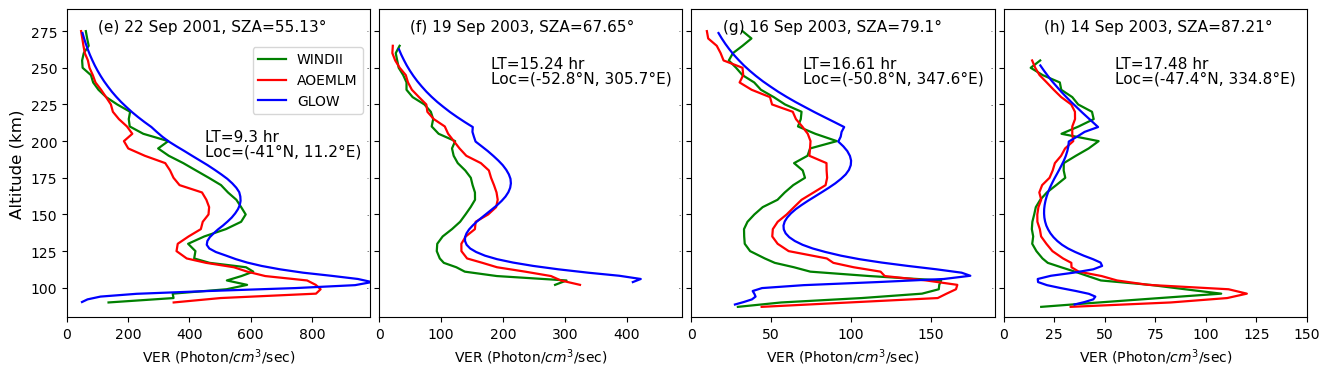

In [21]:
v1=dset_evl[(dset_evl['latitude']==-41.0) & (dset_evl['longitude']==11.2) & (dset_evl['SZA']==55.13)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)
plt.subplot(1,4,1)
plt.xlim(0,990)
plt.ylim(80,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(100,275,'(e) 22 Sep 2001, SZA=55.13\N{DEGREE SIGN}',fontsize=11)                    
#plt.text(100,80,'LT=9.3 hr, Loc=(-41.0\N{DEGREE SIGN}N, 11.2\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(450,200,'LT=9.3 hr',fontsize=11)
plt.text(450,190,'Loc=(-41\N{DEGREE SIGN}N, 11.2\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2001, 9, 22, 8, round(43*60/100), 0)
glat = -41
glon = 11.2
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==-52.8) & (dset_evl['longitude']==305.7) & (dset_evl['SZA']==67.65)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
plt.xlim(0,490)
plt.ylim(80,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(50,275,'(f) 19 Sep 2003, SZA=67.65\N{DEGREE SIGN}',fontsize=11)
#plt.text(30,80,'LT=15.24 hr, Loc=(-52.8\N{DEGREE SIGN}N, 305.7\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(180,250,'LT=15.24 hr',fontsize=11)
plt.text(180,240,'Loc=(-52.8\N{DEGREE SIGN}N, 305.7\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 9, 19, 18, 45, 0)
glat = -52.8
glon = 305.7-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==-50.8) & (dset_evl['longitude']==347.6) & (dset_evl['SZA']==79.1)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,4,3)
plt.xlim(0,190)
plt.ylim(80,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(20,275,'(g) 16 Sep 2003, SZA=79.1\N{DEGREE SIGN}',fontsize=11)
#plt.text(12,80,'LT=16.61 hr, Loc=(-50.8\N{DEGREE SIGN}N, 347.6\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(70,250,'LT=16.61 hr',fontsize=11)
plt.text(70,240,'Loc=(-50.8\N{DEGREE SIGN}N, 347.6\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 9, 16, 17, int(35*60/100), 0)
glat = -50.8
glon = 347.6-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==-47.4) & (dset_evl['longitude']== 334.8) & (dset_evl['SZA']==87.21)]
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
plt.xlim(0,150)
plt.ylim(80,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(20,275,'(h) 14 Sep 2003, SZA=87.21\N{DEGREE SIGN}',fontsize=11)
#plt.text(10,80,'LT=17.48 hr,Loc=(-47.4\N{DEGREE SIGN}N, 334.8\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(55,250,'LT=17.48 hr',fontsize=11)
plt.text(55,240,'Loc=(-47.4\N{DEGREE SIGN}N, 334.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2003, 9, 14, 19, 5, 0)
glat = -47.4
glon = 334.8-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

#plt.savefig('Sep_MH.png', dpi=800, bbox_inches='tight')
#plt.savefig('Sep_MH.eps', dpi=800, bbox_inches='tight')

In [22]:
#************ December

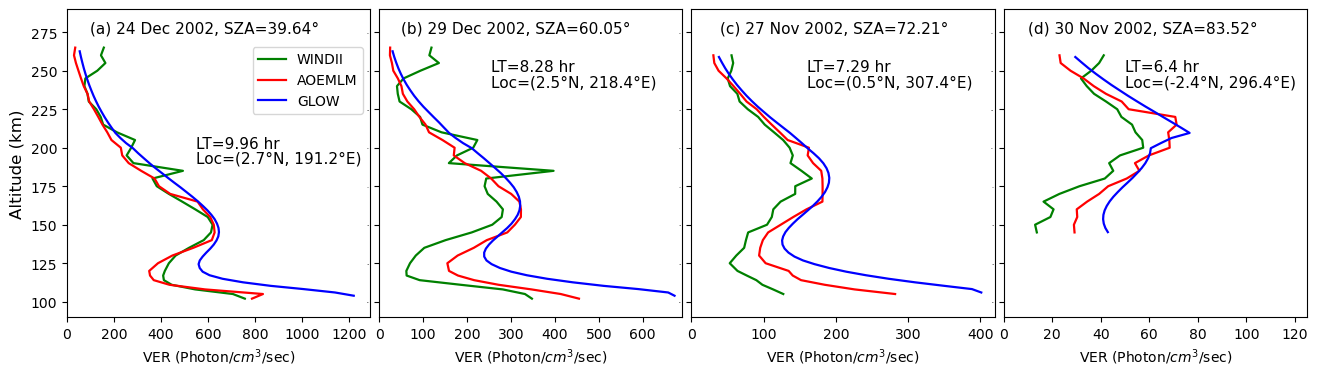

In [23]:
v1=dset_evl[(dset_evl['latitude']==2.7) & (dset_evl['longitude']==191.2) & (dset_evl['SZA']==39.64)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)

plt.subplot(1,4,1)
plt.xlim(0,1290)
plt.ylim(90,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(100,275,'(a) 24 Dec 2002, SZA=39.64\N{DEGREE SIGN}',fontsize=11)                    
#plt.text(130,80,'LT=9.96 hr, Loc=(2.7\N{DEGREE SIGN}N, 191.2\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(550,200,'LT=9.96 hr',fontsize=11)
plt.text(550,190,'Loc=(2.7\N{DEGREE SIGN}N, 191.2\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 12, 24, 21, 12, 0)
glat = 2.7
glon = 191.2-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==2.5) & (dset_evl['longitude']==218.4) & (dset_evl['SZA']==60.05)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
plt.xlim(0,690)
plt.ylim(90,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(50,275,'(b) 29 Dec 2002, SZA=60.05\N{DEGREE SIGN}',fontsize=11)
#plt.text(70,80,'LT=8.28 hr, Loc=(2.5\N{DEGREE SIGN}N, 218.4\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(255,250,'LT=8.28 hr',fontsize=11)
plt.text(255,240,'Loc=(2.5\N{DEGREE SIGN}N, 218.4\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 12, 29, 17, 45, 0)
glat = 2.5
glon = 218.4-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==0.5) & (dset_evl['longitude']==307.4) & (dset_evl['SZA']==72.21)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,4,3)
plt.xlim(0,420)
plt.ylim(90,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(40,275,'(c) 27 Nov 2002, SZA=72.21\N{DEGREE SIGN}',fontsize=11)
#plt.text(45,80,'LT=7.29 hr, Loc=(0.5\N{DEGREE SIGN}N, 307.4\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(160,250,'LT=7.29 hr',fontsize=11)
plt.text(160,240,'Loc=(0.5\N{DEGREE SIGN}N, 307.4\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 27, 10, 36, 0)
glat = 0.5
glon = 307.4-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==-2.4) & (dset_evl['longitude']== 296.4) & (dset_evl['SZA']==83.52)]
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
plt.xlim(0,125)
plt.ylim(90,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,275,'(d) 30 Nov 2002, SZA=83.52\N{DEGREE SIGN}',fontsize=11)
#plt.text(15,80,'LT=6.4 hr, Loc=(-2.4\N{DEGREE SIGN}N, 296.4\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(50,250,'LT=6.4 hr',fontsize=11)
plt.text(50,240,'Loc=(-2.4\N{DEGREE SIGN}N, 296.4\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 30, 10, 27, 0)
glat = -2.4
glon = 296.4-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

#plt.savefig('Dec_L.png', dpi=800, bbox_inches='tight')
#plt.savefig('Dec_L.eps', dpi=800, bbox_inches='tight')

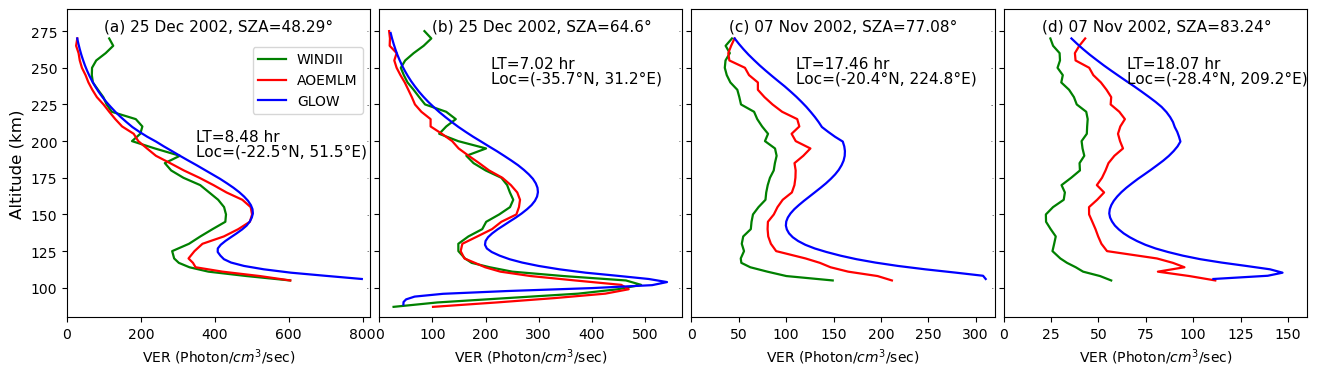

In [24]:
v1=dset_evl[(dset_evl['latitude']==-22.5) & (dset_evl['longitude']==51.5) & (dset_evl['SZA']==48.29)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)

plt.subplot(1,4,1)
plt.xlim(0,820)
plt.ylim(80,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(100,275,'(a) 25 Dec 2002, SZA=48.29\N{DEGREE SIGN}',fontsize=11)                    
#plt.text(80,80,'LT=8.48 hr, Loc=(-22.5\N{DEGREE SIGN}N, 51.5\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(350,200,'LT=8.48 hr',fontsize=11)
plt.text(350,190,'Loc=(-22.5\N{DEGREE SIGN}N, 51.5\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 12, 25, 5, 2, 0)
glat = -22.5
glon = 51.5
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==-35.7) & (dset_evl['longitude']==31.2) & (dset_evl['SZA']==64.6)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']

plt.subplot(1,4,2)
plt.xlim(0,570)
plt.ylim(80,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(100,275,'(b) 25 Dec 2002, SZA=64.6\N{DEGREE SIGN}',fontsize=11)
#plt.text(50,80,'LT=7.02 hr, Loc=(-35.7\N{DEGREE SIGN}N, 31.2\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(210,250,'LT=7.02 hr',fontsize=11)
plt.text(210,240,'Loc=(-35.7\N{DEGREE SIGN}N, 31.2\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 12, 25, 4, 57, 0)
glat = -35.7
glon = 31.2
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==-20.4) & (dset_evl['longitude']==224.8) & (dset_evl['SZA']==77.08)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']

plt.subplot(1,4,3)
plt.xlim(0,320)
plt.ylim(80,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(40,275,'(c) 07 Nov 2002, SZA=77.08\N{DEGREE SIGN}',fontsize=11)
#plt.text(15,80,'LT=17.46 hr, Loc=(-20.4\N{DEGREE SIGN}N, 224.8\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(110,250,'LT=17.46 hr',fontsize=11)
plt.text(110,240,'Loc=(-20.4\N{DEGREE SIGN}N, 224.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 7, 2, 12, 0)
glat = -20.4
glon = 224.8-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)


v4=dset_evl[(dset_evl['latitude']==-28.4) & (dset_evl['longitude']== 209.2) & (dset_evl['SZA']==83.24)]
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
plt.xlim(0,160)
plt.ylim(80,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(20,275,'(d) 07 Nov 2002, SZA=83.24\N{DEGREE SIGN}',fontsize=11)
#plt.text(10,80,'LT=18.07 hr,Loc=(-28.4\N{DEGREE SIGN}N, 209.2\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(65,250,'LT=18.07 hr',fontsize=11)
plt.text(65,240,'Loc=(-28.4\N{DEGREE SIGN}N, 209.2\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 7, 3, 50, 0)
glat = -28.4
glon = 209.2-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

#plt.savefig('Dec_M.png', dpi=800, bbox_inches='tight')
#plt.savefig('Dec_M.eps', dpi=800, bbox_inches='tight')

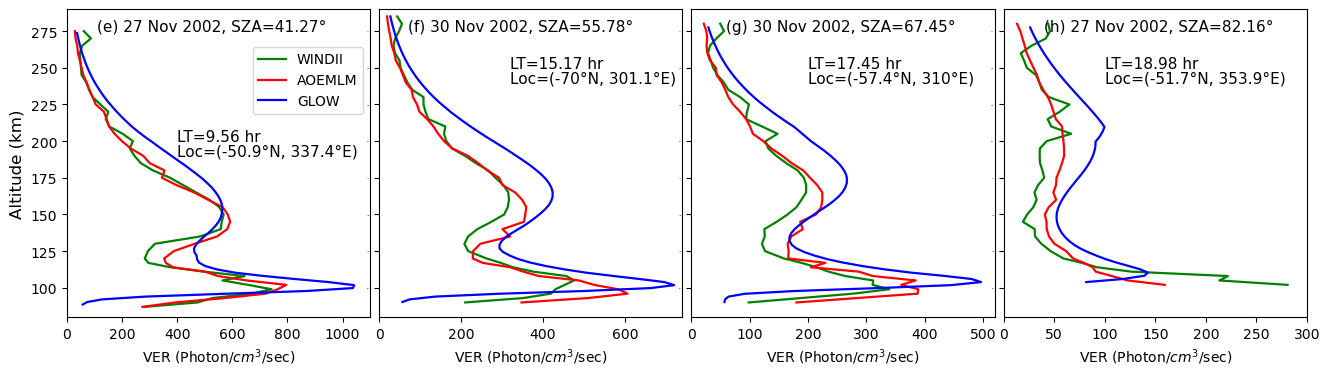

In [25]:
v1=dset_evl[(dset_evl['latitude']==-50.9) & (dset_evl['longitude']==337.4) & (dset_evl['SZA']==41.27)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)

plt.subplot(1,4,1)
plt.xlim(0,1100)
plt.ylim(80,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(110,275,'(e) 27 Nov 2002, SZA=41.27\N{DEGREE SIGN}',fontsize=11)                    
#plt.text(80,80,'LT=9.56 hr, Loc=(-50.9\N{DEGREE SIGN}N, 337.4\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(400,200,'LT=9.56 hr',fontsize=11)
plt.text(400,190,'Loc=(-50.9\N{DEGREE SIGN}N, 337.4\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 27, 10, 51, 0)
glat = -50.9
glon = 337.4-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==-70.0) & (dset_evl['longitude']==301.1) & (dset_evl['SZA']==55.78)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
plt.xlim(0,740)
plt.ylim(80,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(70,275,'(f) 30 Nov 2002, SZA=55.78\N{DEGREE SIGN}',fontsize=11)
#plt.text(50,80,'LT=15.17 hr, Loc=(-70.0\N{DEGREE SIGN}N, 301.1\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(320,250,'LT=15.17 hr',fontsize=11)
plt.text(320,240,'Loc=(-70\N{DEGREE SIGN}N, 301.1\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 30, 18, 54, 0)
glat = -70
glon = 301.1-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==-57.4) & (dset_evl['longitude']==310.0) & (dset_evl['SZA']==67.45)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']

plt.subplot(1,4,3)
plt.xlim(0,520)
plt.ylim(80,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(60,275,'(g) 30 Nov 2002, SZA=67.45\N{DEGREE SIGN}',fontsize=11)
#plt.text(40,80,'LT=17.45 hr, Loc=(-57.4\N{DEGREE SIGN}N, 310.0\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(200,250,'LT=17.45 hr',fontsize=11)
plt.text(200,240,'Loc=(-57.4\N{DEGREE SIGN}N, 310\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 30, 20, 36, 0)
glat = -57.4
glon = 310-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==-51.7) & (dset_evl['longitude']== 353.9) & (dset_evl['SZA']==82.16)].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']

plt.subplot(1,4,4)
plt.xlim(0,300)
plt.ylim(80,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(40,275,'(h) 27 Nov 2002, SZA=82.16\N{DEGREE SIGN}',fontsize=11)
#plt.text(20,80,'LT=18.98 hr, Loc=(-51.7\N{DEGREE SIGN}N, 353.9\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(100,250,'LT=18.98 hr',fontsize=11)
plt.text(100,240,'Loc=(-51.7\N{DEGREE SIGN}N, 353.9\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2002, 11, 27, 19, 10, 0)
glat = -51.7
glon = 353.9-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('Dec_H.png', dpi=800, bbox_inches='tight')
#plt.savefig('Dec_H.eps', dpi=800, bbox_inches='tight')

In [26]:
#*************** F10.7 test dataset

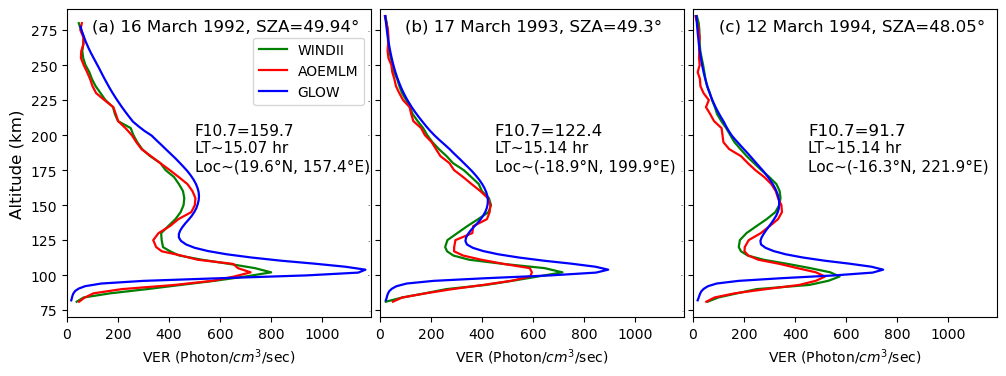

In [27]:
dset_evl=pd.read_csv('F107 test_set.csv')

v1=dset_evl[(dset_evl['latitude']==19.6) & (dset_evl['longitude']==157.4) & (dset_evl['SZA']==49.94)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(3,figsize=(12,4))
plt.subplots_adjust(wspace=0.03)

plt.subplot(1,3,1)
plt.xlim(0,1190)
plt.ylim(70,290)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(100,275,'(a) 16 March 1992, SZA=49.94\N{DEGREE SIGN}',fontsize=12)                    
#plt.text(60,75,'LT=15.07 hr, Loc=(19.6\N{DEGREE SIGN}N, 157.4\N{DEGREE SIGN}E)',fontsize=11)
plt.text(500,200,'F10.7=159.7',fontsize=11)
plt.text(500,188,'LT~15.07 hr',fontsize=11)
plt.text(500,175,'Loc~(19.6\N{DEGREE SIGN}N, 157.4\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1992, 3, 16, 4, 43, 0)
glat = 19.6
glon = 157.4
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.93),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==-18.9) & (dset_evl['longitude']==199.9) & (dset_evl['SZA']==49.3)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,3,2)
plt.xlim(0,1190)
plt.ylim(70,290)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(450,200,'F10.7=122.4',fontsize=12)
plt.text(450,188,'LT~15.14 hr',fontsize=11)
plt.text(450,175,'Loc~(-18.9\N{DEGREE SIGN}N, 199.9\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,275,'(b) 17 March 1993, SZA=49.3\N{DEGREE SIGN}',fontsize=12)
#plt.text(60,75,'LT=15.14 hr, Loc=(-18.9\N{DEGREE SIGN}N, 199.9\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1993, 3, 17, 1, 57, 0)
glat = -18.9
glon = 199.9-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==-16.3) & (dset_evl['longitude']==221.9) & (dset_evl['SZA']==48.05)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,3,3)
plt.xlim(0,1190)
plt.ylim(70,290)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(450,200,'F10.7=91.7',fontsize=12)
plt.text(450,188,'LT~15.14 hr',fontsize=11)
plt.text(450,175,'Loc~(-16.3\N{DEGREE SIGN}N, 221.9\N{DEGREE SIGN}E)',fontsize=11)

plt.text(100,275,'(c) 12 March 1994, SZA=48.05\N{DEGREE SIGN}',fontsize=12)
#plt.text(60,75,'LT=15.14 hr, Loc=(-16.3\N{DEGREE SIGN}N, 221.9\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1994, 3, 12, 0, 37, 0)
glat = -16.3
glon = 221.9-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

#plt.savefig('F107_L3.png',dpi=800, bbox_inches='tight')
#plt.savefig('F107_L3.eps',dpi=800, bbox_inches='tight')

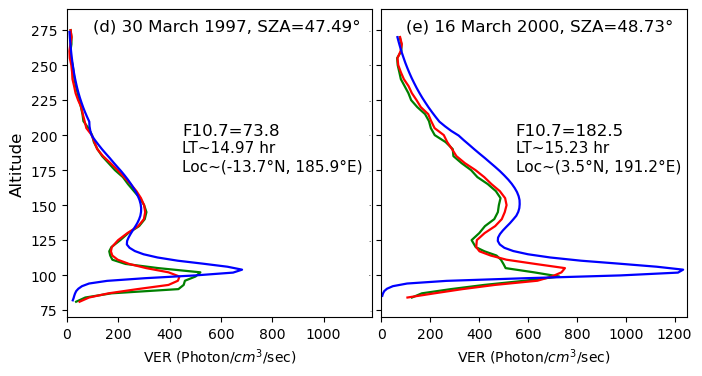

In [28]:
fig, axs = plt.subplots(2,figsize=(8,4))
plt.subplots_adjust(wspace=0.03)

v4=dset_evl[(dset_evl['latitude']==-13.7) & (dset_evl['longitude']== 185.9) & (dset_evl['SZA']==47.49)].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,2,1)
plt.xlim(0,1190)
plt.ylim(70,290)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude',fontsize=12)
plt.yticks(fontsize=10)
plt.text(450,200,'F10.7=73.8',fontsize=12)
plt.text(450,188,'LT~14.97 hr',fontsize=11)
plt.text(450,175,'Loc~(-13.7\N{DEGREE SIGN}N, 185.9\N{DEGREE SIGN}E)',fontsize=11)

plt.text(100,275,'(d) 30 March 1997, SZA=47.49\N{DEGREE SIGN}',fontsize=12)
#plt.text(60,75,'LT=14.97 hr, Loc=(-13.7\N{DEGREE SIGN}N, 185.9\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1997, 3, 30, 2, 39, 0)
glat = -13.7
glon = 185.9-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v5=dset_evl[(dset_evl['latitude']==3.5) & (dset_evl['longitude']== 191.2) & (dset_evl['SZA']==48.73)].sort_values(by='altitude')
input_v5= v5[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x5 = v5['VER']
pre_x5=model.predict(input_v5)
y5= v5['altitude']
plt.subplot(1,2,2)
plt.xlim(0,1250)
plt.ylim(70,290)
plt.plot(x5,y5,color='green',linewidth=1.6)
plt.plot(pre_x5,y5,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(550,200,'F10.7=182.5',fontsize=12)
plt.text(550,188,'LT~15.23 hr',fontsize=11)
plt.text(550,175,'Loc~(3.5\N{DEGREE SIGN}N, 191.2\N{DEGREE SIGN}E)',fontsize=11)

plt.text(100,275,'(e) 16 March 2000, SZA=48.73\N{DEGREE SIGN}',fontsize=12)
#plt.text(60,75,'LT=15.23 hr, Loc=(3.5\N{DEGREE SIGN}N, 191.2\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2000, 3, 16, 2, 38, 0)
glat = 3.5
glon = 191.2-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v5['altitude'].min())& (df['alt']<=v5['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

#plt.savefig('F107_L2.png',dpi=800, bbox_inches='tight')
#plt.savefig('F107_L2.eps',dpi=800, bbox_inches='tight')

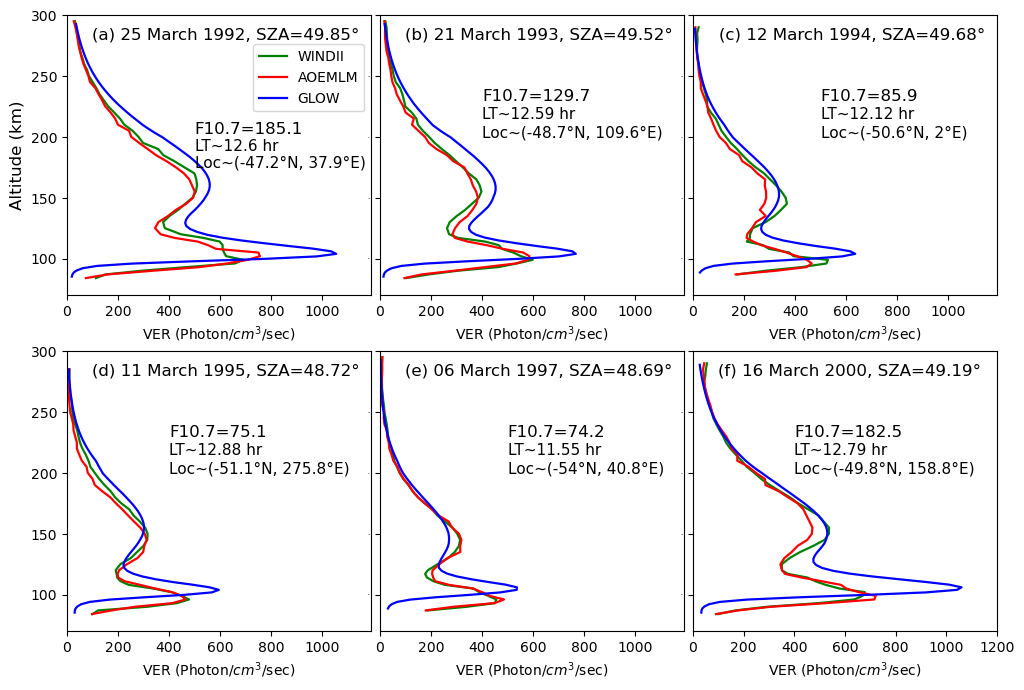

In [29]:
v1=dset_evl[(dset_evl['latitude']==-47.2) & (dset_evl['longitude']==37.9) & (dset_evl['SZA']==49.85)].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(6,figsize=(12,8))
plt.subplots_adjust(wspace=0.03)

plt.subplot(2,3,1)
plt.xlim(0,1190)
plt.ylim(70,300)
plt.plot(x1,y1,color='green',linewidth=1.6,label='WINDII')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(500,203,'F10.7=185.1',fontsize=12)
plt.text(500,189,'LT~12.6 hr',fontsize=11)
plt.text(500,175,'Loc~(-47.2\N{DEGREE SIGN}N, 37.9\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,280,'(a) 25 March 1992, SZA=49.85\N{DEGREE SIGN}',fontsize=12)                    
#plt.text(75,75,'LT=12.6 hr, Loc=(-47.2\N{DEGREE SIGN}N, 37.9\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1992, 3, 25, 10, 10, 30)
glat = -47.2
glon = 37.9
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.92),fontsize=10)

v2=dset_evl[(dset_evl['latitude']==-48.7) & (dset_evl['longitude']==109.6) & (dset_evl['SZA']==49.52)].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(2,3,2)
plt.xlim(0,1190)
plt.ylim(70,300)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(400,230,'F10.7=129.7',fontsize=12)
plt.text(400,215,'LT~12.59 hr',fontsize=11)
plt.text(400,200,'Loc~(-48.7\N{DEGREE SIGN}N, 109.6\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,280,'(b) 21 March 1993, SZA=49.52\N{DEGREE SIGN}',fontsize=12)
#plt.text(75,75,'LT=12.59 hr, Loc=(-48.7\N{DEGREE SIGN}N, 109.6\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1993, 3, 21, 5, 24, 0)
glat = -48.7
glon = 109.6
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v3=dset_evl[(dset_evl['latitude']==-50.6) & (dset_evl['longitude']==2.0) & (dset_evl['SZA']==49.68)].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(2,3,3)
plt.xlim(0,1190)
plt.ylim(70,300)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(500,230,'F10.7=85.9',fontsize=12)
plt.text(500,215,'LT~12.12 hr',fontsize=11)
plt.text(500,200,'Loc~(-50.6\N{DEGREE SIGN}N, 2\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,280,'(c) 12 March 1994, SZA=49.68\N{DEGREE SIGN}',fontsize=12)
#plt.text(75,75,'LT=12.12 hr, Loc=(-50.6\N{DEGREE SIGN}N, 2.0\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1994, 3, 18, 12, 6, 30)
glat = -50.6
glon = 2
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dset_evl[(dset_evl['latitude']==-51.1) & (dset_evl['longitude']== 275.8) & (dset_evl['SZA']==48.72)].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(2,3,4)
plt.xlim(0,1190)
plt.ylim(70,300)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=10)
plt.text(400,230,'F10.7=75.1',fontsize=12)
plt.text(400,215,'LT~12.88 hr',fontsize=11)
plt.text(400,200,'Loc~(-51.1\N{DEGREE SIGN}N, 275.8\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,280,'(d) 11 March 1995, SZA=48.72\N{DEGREE SIGN}',fontsize=12)
#plt.text(75,75,'LT=12.88 hr,Loc=(-51.1\N{DEGREE SIGN}N, 275.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1995, 3, 11, 18, 39, 0)
glat = -51.1
glon = 275.8-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)


v5=dset_evl[(dset_evl['latitude']==-54) & (dset_evl['longitude']== 40.8) & (dset_evl['SZA']==48.69)].sort_values(by='altitude')
input_v5= v5[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x5 = v5['VER']
pre_x5=model.predict(input_v5)
y5= v5['altitude']
plt.subplot(2,3,5)
plt.xlim(0,1190)
plt.ylim(70,300)
plt.plot(x5,y5,color='green',linewidth=1.6)
plt.plot(pre_x5,y5,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(500,230,'F10.7=74.2',fontsize=12)
plt.text(500,215,'LT~11.55 hr',fontsize=11)
plt.text(500,200,'Loc~(-54\N{DEGREE SIGN}N, 40.8\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,280,'(e) 06 March 1997, SZA=48.69\N{DEGREE SIGN}',fontsize=12)
#plt.text(75,75,'LT=11.55 hr, Loc=(-54\N{DEGREE SIGN}N, 40.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(1997, 3, 10, 9, 0, 30)
glat = -54
glon = 40.8
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v5['altitude'].min())& (df['alt']<=v5['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v6=dset_evl[(dset_evl['latitude']==-49.8) & (dset_evl['longitude']== 158.8) & (dset_evl['SZA']==49.19)].sort_values(by='altitude')
input_v6= v6[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x6 = v6['VER']
pre_x6=model.predict(input_v6)
y6= v6['altitude']
plt.subplot(2,3,6)
plt.xlim(0,1200)
plt.ylim(70,300)
plt.plot(x6,y6,color='green',linewidth=1.6)
plt.plot(pre_x6,y6,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(400,230,'F10.7=182.5',fontsize=12)
plt.text(400,215,'LT~12.79 hr',fontsize=11)
plt.text(400,200,'Loc~(-49.8\N{DEGREE SIGN}N, 158.8\N{DEGREE SIGN}E)',fontsize=11)
plt.text(100,280,'(f) 16 March 2000, SZA=49.19\N{DEGREE SIGN}',fontsize=12)
#plt.text(75,75,'LT=12.79 hr,Loc=(-49.8\N{DEGREE SIGN}N, 158.8\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2000, 3, 16, 2, 21, 0)
glat = -49.8
glon = 158.8
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v6['altitude'].min())& (df['alt']<=v6['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

#plt.savefig('F107_H.png',dpi=800, bbox_inches='tight')
#plt.savefig('F107_H.eps',dpi=800, bbox_inches='tight')

In [30]:
# Mighti data Test

In [31]:
dfm=pd.read_csv('MIGHTI_OMNI_data.csv')

In [32]:
#March

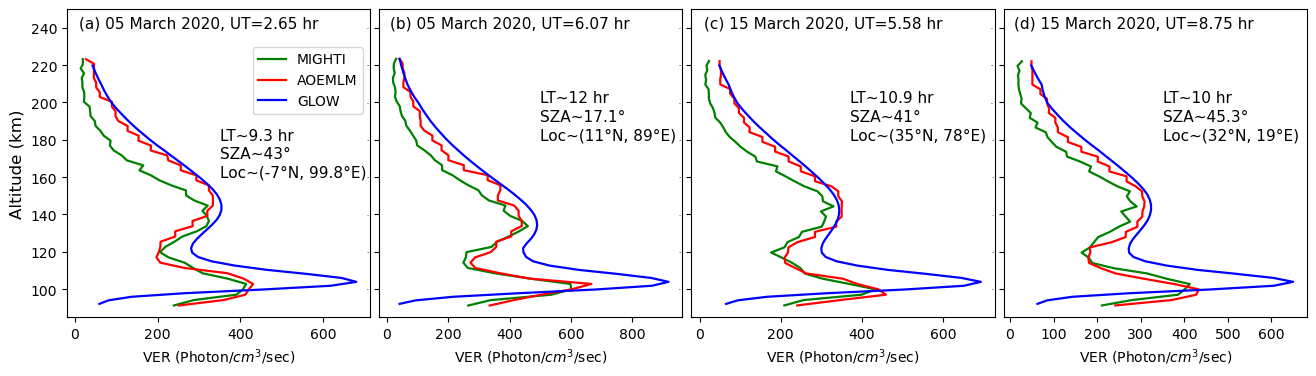

In [33]:
dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==65)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)

v1=dfeq[(dfeq['DOY']==65)&(dfeq['UT']==ut[4])].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)

plt.subplot(1,4,1)
#plt.xlim(0,700)
plt.ylim(85,250)
plt.plot(x1,y1,color='green',linewidth=1.6,label='MIGHTI')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(10,240,'(a) 05 March 2020, UT=2.65 hr',fontsize=11)                    
#plt.text(2,80,'LT~9.3 hr, SZA~43\N{DEGREE SIGN}, Loc~(-7\N{DEGREE SIGN}N,99.8\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(350,180,'LT~9.3 hr',fontsize=11)
plt.text(350,170,'SZA~43\N{DEGREE SIGN}',fontsize=11)
plt.text(350,160,'Loc~(-7\N{DEGREE SIGN}N, 99.8\N{DEGREE SIGN}E)',fontsize=11)

time = datetime(2020, 3, 5, 2, 39, 2)
glat = v1['latitude'].mean()
glon = v1['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

v2=dfeq[(dfeq['DOY']==65)&(dfeq['UT']==ut[85])].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']

plt.subplot(1,4,2)
#plt.xlim(0,500)
plt.ylim(85,250)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(b) 05 March 2020, UT=6.07 hr',fontsize=11)
#plt.text(0,80,'LT~12 hr, SZA~17.1\N{DEGREE SIGN},Loc~(11\N{DEGREE SIGN}N,89\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(500,200,'LT~12 hr',fontsize=11)
plt.text(500,190,'SZA~17.1\N{DEGREE SIGN}',fontsize=11)
plt.text(500,180,'Loc~(11\N{DEGREE SIGN}N, 89\N{DEGREE SIGN}E)',fontsize=11)

time = datetime(2020, 3, 5, 6, 4, 17)
glat = v2['latitude'].mean()
glon = v2['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==75)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v3=dfeq[(dfeq['DOY']==75)&(dfeq['UT']==ut[124])].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']

plt.subplot(1,4,3)
#plt.xlim(0,300)
plt.ylim(85,250)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(c) 15 March 2020, UT=5.58 hr',fontsize=11)
#plt.text(0,80,'LT~10.9 hr, SZA~41\N{DEGREE SIGN},Loc~(35\N{DEGREE SIGN}N,78\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(370,200,'LT~10.9 hr',fontsize=11)
plt.text(370,190,'SZA~41\N{DEGREE SIGN}',fontsize=11)
plt.text(370,180,'Loc~(35\N{DEGREE SIGN}N, 78\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 3, 15, 5, 34, 58)
glat = v3['latitude'].mean()
glon = v3['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

v4=dfeq[(dfeq['DOY']==75)&(dfeq['UT']==ut[170])].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']

plt.subplot(1,4,4)
#plt.xlim(0,125)
plt.yticks(fontsize=0)
plt.ylim(85,250)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.text(10,240,'(d) 15 March 2020, UT=8.75 hr',fontsize=11)
#plt.text(2,80,'LT~10 hr, SZA~45.3\N{DEGREE SIGN}, Loc~(32\N{DEGREE SIGN}N, 19\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(350,200,'LT~10 hr',fontsize=11)
plt.text(350,190,'SZA~45.3\N{DEGREE SIGN}',fontsize=11)
plt.text(350,180,'Loc~(32\N{DEGREE SIGN}N, 19\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 3, 15, 8, 45, 0)
glat = v4['latitude'].mean()
glon = v4['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('mighti_march.png', dpi=800, bbox_inches='tight')
#plt.savefig('mighti_march.eps', dpi=800, bbox_inches='tight')

In [34]:
#June

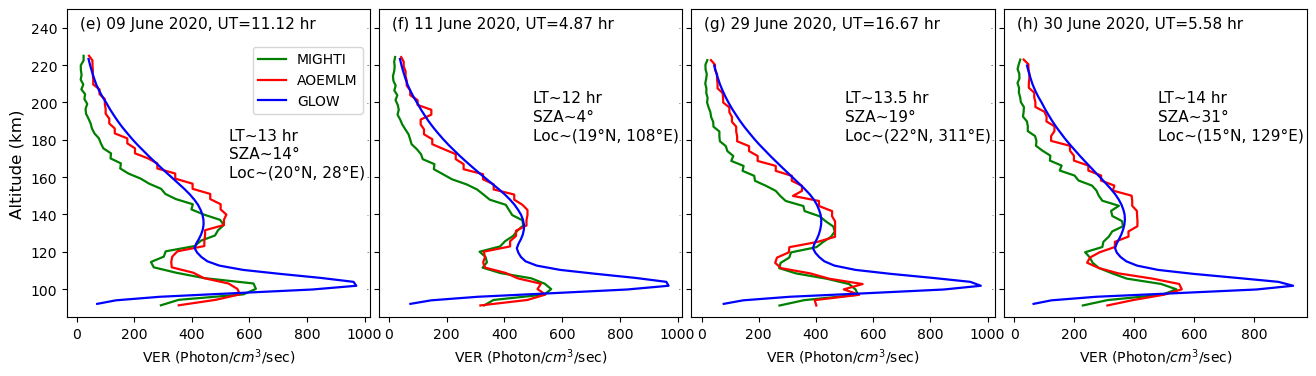

In [35]:
dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==161)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v1=dfeq[(dfeq['DOY']==161)&(dfeq['UT']==ut[3])].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)
plt.subplot(1,4,1)
#plt.xlim(0,700)
plt.ylim(85,250)
plt.plot(x1,y1,color='green',linewidth=1.6,label='MIGHTI')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(10,240,'(e) 09 June 2020, UT=11.12 hr',fontsize=11)                    
#plt.text(10,80,'LT~13 hr, SZA~14\N{DEGREE SIGN}, Loc~(20\N{DEGREE SIGN}N,28\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(530,180,'LT~13 hr',fontsize=11)
plt.text(530,170,'SZA~14\N{DEGREE SIGN}',fontsize=11)
plt.text(530,160,'Loc~(20\N{DEGREE SIGN}N, 28\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 6, 9, 11, 7, 32)
glat = v1['latitude'].mean()
glon = v1['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==163)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v2=dfeq[(dfeq['DOY']==163)&(dfeq['UT']==ut[3])].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
#plt.xlim(0,500)
plt.ylim(85,250)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(f) 11 June 2020, UT=4.87 hr',fontsize=11)
#plt.text(10,80,'LT~12 hr, SZA~4\N{DEGREE SIGN},Loc~(19\N{DEGREE SIGN}N,108\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(500,200,'LT~12 hr',fontsize=11)
plt.text(500,190,'SZA~4\N{DEGREE SIGN}',fontsize=11)
plt.text(500,180,'Loc~(19\N{DEGREE SIGN}N, 108\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 6, 11, 4, 52, 24)
glat = v2['latitude'].mean()
glon = v2['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==181)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v3=dfeq[(dfeq['DOY']==181)&(dfeq['UT']==ut[1])].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,4,3)
#plt.xlim(0,300)
plt.ylim(85,250)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(g) 29 June 2020, UT=16.67 hr',fontsize=11)
#plt.text(-10,80,'LT~13.5 hr, SZA~19\N{DEGREE SIGN},Loc~(22\N{DEGREE SIGN}N,311\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(500,200,'LT~13.5 hr',fontsize=11)
plt.text(500,190,'SZA~19\N{DEGREE SIGN}',fontsize=11)
plt.text(500,180,'Loc~(22\N{DEGREE SIGN}N, 311\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 6, 29, 16, 40, 9)
glat = v3['latitude'].mean()
glon = v3['longitude'].mean()-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==182)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v4=dfeq[(dfeq['DOY']==182)&(dfeq['UT']==ut[0])].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
#plt.xlim(0,125)
plt.yticks(fontsize=0)
plt.ylim(85,250)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.text(10,240,'(h) 30 June 2020, UT=5.58 hr',fontsize=11)
#plt.text(2,80,'LT~14 hr, SZA~31\N{DEGREE SIGN}, Loc~(15\N{DEGREE SIGN}N, 129\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(480,200,'LT~14 hr',fontsize=11)
plt.text(480,190,'SZA~31\N{DEGREE SIGN}',fontsize=11)
plt.text(480,180,'Loc~(15\N{DEGREE SIGN}N, 129\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 6, 30, 5, 35, 12)
glat = v4['latitude'].mean()
glon = v4['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('mighti_june.png', dpi=800, bbox_inches='tight')
#plt.savefig('mighti_june.eps', dpi=800, bbox_inches='tight')

In [36]:
#September

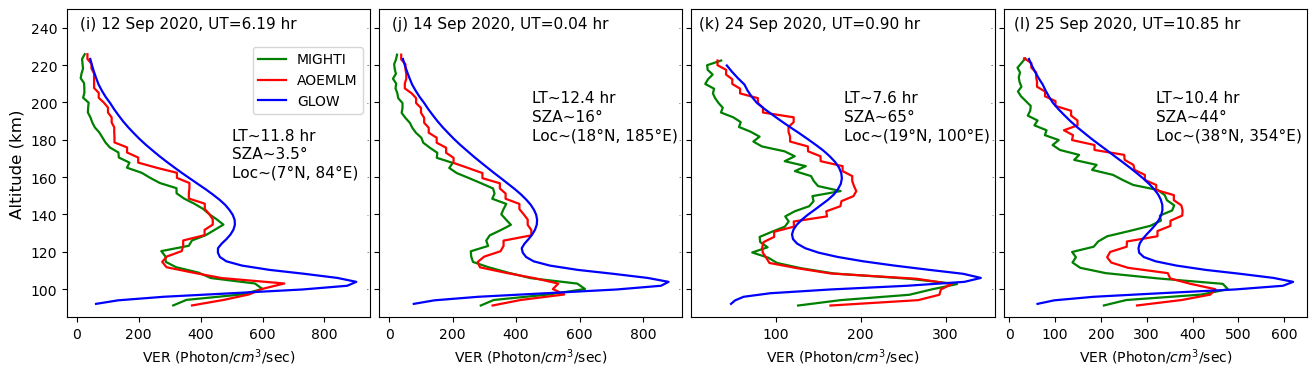

In [37]:
dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==256)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v1=dfeq[(dfeq['DOY']==256)&(dfeq['UT']==ut[1])].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)
plt.subplot(1,4,1)
#plt.xlim(0,700)
plt.ylim(85,250)
plt.plot(x1,y1,color='green',linewidth=1.6,label='MIGHTI')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(10,240,'(i) 12 Sep 2020, UT=6.19 hr',fontsize=11)                    
#plt.text(0,80,'LT~11.8 hr, SZA~3.5\N{DEGREE SIGN}, Loc~(7\N{DEGREE SIGN}N,84\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(500,180,'LT~11.8 hr',fontsize=11)
plt.text(500,170,'SZA~3.5\N{DEGREE SIGN}',fontsize=11)
plt.text(500,160,'Loc~(7\N{DEGREE SIGN}N, 84\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 9, 12, 6, 11, 26)
glat = v1['latitude'].mean()
glon = v1['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==258)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v2=dfeq[(dfeq['DOY']==258)&(dfeq['UT']==ut[0])].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
#plt.xlim(0,500)
plt.ylim(85,250)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(j) 14 Sep 2020, UT=0.04 hr',fontsize=11)
#plt.text(-10,80,'LT~12.4 hr, SZA~16\N{DEGREE SIGN},Loc~(18\N{DEGREE SIGN}N,185\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(450,200,'LT~12.4 hr',fontsize=11)
plt.text(450,190,'SZA~16\N{DEGREE SIGN}',fontsize=11)
plt.text(450,180,'Loc~(18\N{DEGREE SIGN}N, 185\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 9, 14, 0, 2, 42)
glat = v2['latitude'].mean()
glon = v2['longitude'].mean()-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==268)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v3=dfeq[(dfeq['DOY']==268)&(dfeq['UT']==ut[0])].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,4,3)
#plt.xlim(0,300)
plt.ylim(85,250)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(k) 24 Sep 2020, UT=0.90 hr',fontsize=11)
#plt.text(10,80,'LT~7.6 hr, SZA~65\N{DEGREE SIGN},Loc~(19\N{DEGREE SIGN}N,100\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(180,200,'LT~7.6 hr',fontsize=11)
plt.text(180,190,'SZA~65\N{DEGREE SIGN}',fontsize=11)
plt.text(180,180,'Loc~(19\N{DEGREE SIGN}N, 100\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 9, 24, 0, 54, 32)
glat = v3['latitude'].mean()
glon = v3['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==269)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v4=dfeq[(dfeq['DOY']==269)&(dfeq['UT']==ut[27])].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
#plt.xlim(0,125)
plt.yticks(fontsize=0)
plt.ylim(85,250)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.text(10,240,'(l) 25 Sep 2020, UT=10.85 hr',fontsize=11)
#plt.text(-5,80,'LT~10.4 hr, SZA~44\N{DEGREE SIGN}, Loc~(38\N{DEGREE SIGN}N,354\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(320,200,'LT~10.4 hr',fontsize=11)
plt.text(320,190,'SZA~44\N{DEGREE SIGN}',fontsize=11)
plt.text(320,180,'Loc~(38\N{DEGREE SIGN}N, 354\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 9, 25, 10, 51, 12)
glat = v4['latitude'].mean()
glon = v4['longitude'].mean()-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('mighti_sep.png', dpi=800, bbox_inches='tight')
#plt.savefig('mighti_sep.eps', dpi=800, bbox_inches='tight')

In [38]:
#December

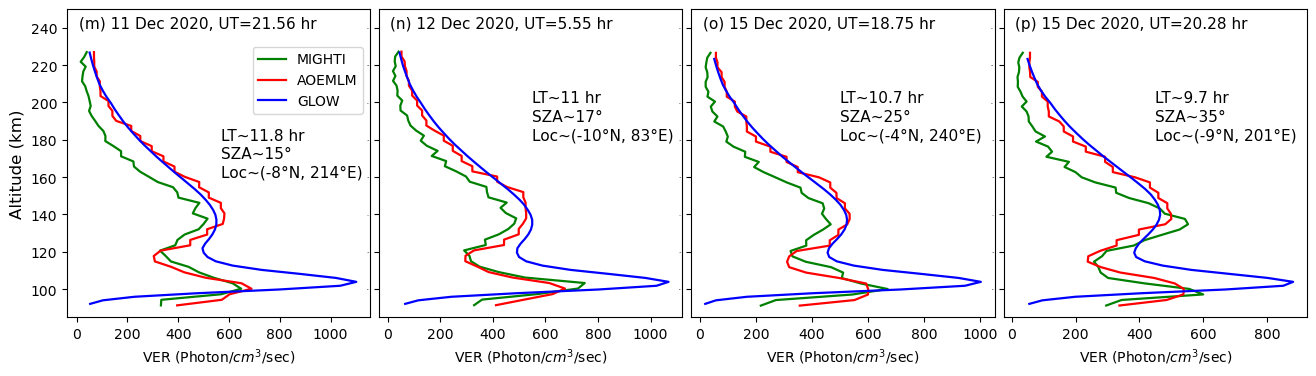

In [39]:
dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==346)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v1=dfeq[(dfeq['DOY']==346)&(dfeq['UT']==ut[8])].sort_values(by='altitude')
input_v1= v1[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x1 = v1['VER']
pre_x1=model.predict(input_v1)
y1= v1['altitude']
fig, axs = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=0.03)
plt.subplot(1,4,1)
#plt.xlim(0,700)
plt.ylim(85,250)
plt.plot(x1,y1,color='green',linewidth=1.6,label='MIGHTI')
plt.plot(pre_x1,y1,color='red',linewidth=1.6,label='AOEMLM')
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.ylabel('Altitude (km)',fontsize=12)
plt.text(10,240,'(m) 11 Dec 2020, UT=21.56 hr',fontsize=11)                    
#plt.text(-5,80,'LT~11.8 hr, SZA~15\N{DEGREE SIGN},Loc~(-8\N{DEGREE SIGN}N,214\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(570,180,'LT~11.8 hr',fontsize=11)
plt.text(570,170,'SZA~15\N{DEGREE SIGN}',fontsize=11)
plt.text(570,160,'Loc~(-8\N{DEGREE SIGN}N, 214\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 12, 11, 21, 33, 59)
glat = v1['latitude'].mean()
glon = v1['longitude'].mean()-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v1['altitude'].min())& (df['alt']<=v1['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',label='GLOW',linewidth=1.6)
plt.legend(bbox_to_anchor=(1, 0.9),fontsize=10)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==347)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v2=dfeq[(dfeq['DOY']==347)&(dfeq['UT']==ut[0])].sort_values(by='altitude')
input_v2= v2[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x2 = v2['VER']
pre_x2=model.predict(input_v2)
y2= v2['altitude']
plt.subplot(1,4,2)
#plt.xlim(0,500)
plt.ylim(85,250)
plt.plot(x2,y2,color='green',linewidth=1.6)
plt.plot(pre_x2,y2,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(n) 12 Dec 2020, UT=5.55 hr',fontsize=11)
#plt.text(10,80,'LT~11 hr, SZA~17\N{DEGREE SIGN},Loc~(-10\N{DEGREE SIGN}N,83\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(550,200,'LT~11 hr',fontsize=11)
plt.text(550,190,'SZA~17\N{DEGREE SIGN}',fontsize=11)
plt.text(550,180,'Loc~(-10\N{DEGREE SIGN}N, 83\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 12, 12, 5, 33, 23)
glat = v2['latitude'].mean()
glon = v2['longitude'].mean()
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v2['altitude'].min())& (df['alt']<=v2['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==350)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v3=dfeq[(dfeq['DOY']==350)&(dfeq['UT']==ut[2])].sort_values(by='altitude')
input_v3= v3[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x3 = v3['VER']
pre_x3=model.predict(input_v3)
y3= v3['altitude']
plt.subplot(1,4,3)
#plt.xlim(0,300)
plt.ylim(85,250)
plt.plot(x3,y3,color='green',linewidth=1.6)
plt.plot(pre_x3,y3,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.yticks(fontsize=0)
plt.text(10,240,'(o) 15 Dec 2020, UT=18.75 hr',fontsize=11)
#plt.text(0,80,'LT~10.7 hr, SZA~25\N{DEGREE SIGN},Loc~(-4\N{DEGREE SIGN}N, 240\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(500,200,'LT~10.7 hr',fontsize=11)
plt.text(500,190,'SZA~25\N{DEGREE SIGN}',fontsize=11)
plt.text(500,180,'Loc~(-4\N{DEGREE SIGN}N, 240\N{DEGREE SIGN}E)',fontsize=11)
time = datetime(2020, 12, 15, 18, 44, 59)
glat = v3['latitude'].mean()
glon = v3['longitude'].mean()-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v3['altitude'].min())& (df['alt']<=v3['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)

dfeq=dfm[(dfm['year']==2020)&(dfm['DOY']==350)]
z=np.array(dfeq['UT'].unique())
ut=np.sort(z)
v4=dfeq[(dfeq['DOY']==350)&(dfeq['UT']==ut[4])].sort_values(by='altitude')
input_v4= v4[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
x4 = v4['VER']
pre_x4=model.predict(input_v4)
y4= v4['altitude']
plt.subplot(1,4,4)
#plt.xlim(0,125)
plt.yticks(fontsize=0)
plt.ylim(85,250)
plt.plot(x4,y4,color='green',linewidth=1.6)
plt.plot(pre_x4,y4,color='red',linewidth=1.6)
plt.xlabel('VER (Photon/$cm^3$/sec)')
plt.text(10,240,'(p) 15 Dec 2020, UT=20.28 hr',fontsize=11)
#plt.text(0,80,'LT~9.7 hr, SZA~35\N{DEGREE SIGN}, Loc~(-9\N{DEGREE SIGN}N,201\N{DEGREE SIGN}E)',fontsize=10.5)
plt.text(450,200,'LT~9.7 hr',fontsize=11)
plt.text(450,190,'SZA~35\N{DEGREE SIGN}',fontsize=11)
plt.text(450,180,'Loc~(-9\N{DEGREE SIGN}N, 201\N{DEGREE SIGN}E)',fontsize=11)

time = datetime(2020, 12, 15, 20, 16, 58)
glat = v4['latitude'].mean()
glon = v4['longitude'].mean()-360
Q = 1
Echar = 100e3
Nbins = 250
iono = glow.maxwellian(time, glat, glon, Q, Echar, Nbins)
gline=iono['ver'][:,3]
df=pd.DataFrame(gline)
alt=np.array(iono['alt_km'])
df.rename(columns={0:'VER'},inplace=True)
df.insert(1,'alt',alt)
dff=df[(df['alt']>=v4['altitude'].min())& (df['alt']<=v4['altitude'].max())]
plt.plot(dff['VER'],dff['alt'],color='blue',linewidth=1.6)
#plt.savefig('mighti_dec.png', dpi=800, bbox_inches='tight')
#plt.savefig('mighti_dec.eps', dpi=800, bbox_inches='tight')

In [40]:
#*************************************************************************************

In [41]:
#daily average of profiles 1992-2000

In [42]:
# Import training dataset
dff=pd.read_csv('F107 test_set.csv')

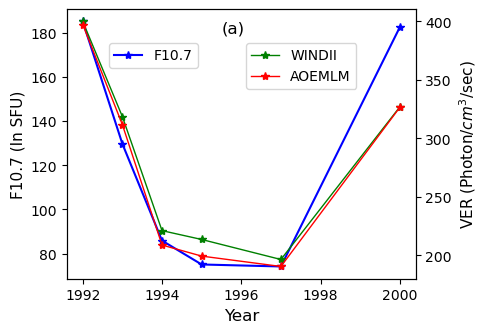

In [43]:
ds=dff
mn=0
mx=60

#ds91=ds[(ds['YEAR']==1991) & (ds['SZA']>=mn)& (ds['SZA']<=mx)]
ds92=ds[(ds['YEAR']==1992)& (ds['SZA']>=mn)& (ds['SZA']<=mx)& (ds['DOY_x']==85)]
input_v= ds92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
pre_92=model.predict(input_v)

ds93=ds[(ds['YEAR']==1993)& (ds['SZA']>=mn)& (ds['SZA']<=mx)& (ds['DOY_x']==80)]
input_v= ds93[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
pre_93=model.predict(input_v)

ds94=ds[(ds['YEAR']==1994)& (ds['SZA']>=mn)& (ds['SZA']<=mx)& (ds['DOY_x']==71)]
input_v= ds94[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
pre_94=model.predict(input_v)

ds95=ds[(ds['YEAR']==1995)& (ds['SZA']>=mn)& (ds['SZA']<=mx)& (ds['DOY_x']==70)]
input_v= ds95[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
pre_95=model.predict(input_v)
#ds96=ds[(ds['YEAR']==1996)& (ds['SZA']>=mn)& (ds['SZA']<=mx)]

ds97=ds[(ds['YEAR']==1997)& (ds['SZA']>=mn)& (ds['SZA']<=mx)& (ds['DOY_x']==65)]
input_v= ds97[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
pre_97=model.predict(input_v)

#ds98=ds[(ds['YEAR']==1998)]
#ds99=ds[(ds['YEAR']==1999)& (ds['SZA']>=mn)& (ds['SZA']<=mx)]
ds20=ds[(ds['YEAR']==2000)& (ds['SZA']>=mn)& (ds['SZA']<=mx)& (ds['DOY_x']==76)]
input_v= ds20[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
pre_20=model.predict(input_v)
#d91=ds91[(ds91['DOY_x']==312)& (ds91['SZA']>=46)& (ds91['SZA']<=85)] # total 303 profiles

year=[1992,1993, 1994, 1995, 1997, 2000]
vr=[ds92['VER'].mean(), ds93['VER'].mean(),ds94['VER'].mean(),ds95['VER'].mean(),ds97['VER'].mean(),ds20['VER'].mean()]

pre=[pre_92.mean(), pre_93.mean(),pre_94.mean(),pre_95.mean(),pre_97.mean(),pre_20.mean()]


f107=[185.1,129.7,85.9,75.1,74.2,182.5]


plt.figure(figsize=(4.5,3.5))
plt.plot(year,f107, c='b',marker='*',label='F10.7',lw=1.5)
plt.xlabel('Year',fontsize=12)
plt.ylabel('F10.7 (In SFU)',fontsize=11)
plt.legend(bbox_to_anchor=(0.1, 0.90))
plt.text(1995.5,180,'(a)',fontsize=12)

plt.twinx()
plt.plot(year,vr, c='g',marker='*',label='WINDII',lw=1)
plt.plot(year,pre, c='r',marker='*',label='AOEMLM',lw=1)

plt.ylabel('VER (Photon/$cm^3$/sec)',fontsize=11)
#plt.ylim(0,200)
plt.legend(bbox_to_anchor=(0.85, 0.90))

#plt.savefig('F107_VER_Daily_SZA_0_to_60.png',dpi=300, bbox_inches='tight')
#plt.savefig('F107_VER_Daily_SZA_0_to_60.eps',dpi=300, bbox_inches='tight')

In [44]:
mn=46
mx=84

d92=dff[(dff['YEAR']==1992)& (dff['DOY_x']==85)& (dff['SZA']>=mn)& (dff['SZA']<=mx)] # total 303 profiles
sza=np.sort(d92['SZA'].unique()) 

li=[]
for i in range(len(sza)):
    p92=d92[(d92['SZA']==sza[i])].sort_values(by='altitude')
    input_v= p92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
    pre_x=model.predict(input_v)
    x = p92['VER']
    y= p92['altitude']

    wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in Rayleigh
    prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in Rayleigh
    
    dfn=pd.DataFrame(p92.mean()).T
    dfn.insert(25,'WINDII',wnd)
    dfn.insert(26,'PRD',prd)
    li.append(dfn)
dfn92=pd.concat(li)
#***************************************************************************************************
d92=dff[(dff['YEAR']==1993)& (dff['DOY_x']==80)& (dff['SZA']>=mn)& (dff['SZA']<=mx)] # total 303 profiles
sza=np.sort(d92['SZA'].unique()) 

li=[]
for i in range(len(sza)):
    p92=d92[(d92['SZA']==sza[i])].sort_values(by='altitude')
    input_v= p92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
    pre_x=model.predict(input_v)
    x = p92['VER']
    y= p92['altitude']

    wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in Rayleigh
    prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in Rayleigh
    
    dfn=pd.DataFrame(p92.mean()).T
    dfn.insert(25,'WINDII',wnd)
    dfn.insert(26,'PRD',prd)
    li.append(dfn)

    #plt.plot(x, y,c='g')
    #plt.plot(pre_x, y,c='r')

dfn93=pd.concat(li)
#****************************************************************************************************
d92=dff[(dff['YEAR']==1994)& (dff['DOY_x']==71)& (dff['SZA']>=mn)& (dff['SZA']<=mx)] # total 303 profiles
sza=np.sort(d92['SZA'].unique()) 

li=[]
for i in range(len(sza)):
    p92=d92[(d92['SZA']==sza[i])].sort_values(by='altitude')
    input_v= p92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
    pre_x=model.predict(input_v)
    x = p92['VER']
    y= p92['altitude']

    wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in Rayleigh
    prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in Rayleigh
    
    dfn=pd.DataFrame(p92.mean()).T
    dfn.insert(25,'WINDII',wnd)
    dfn.insert(26,'PRD',prd)
    li.append(dfn)
dfn94=pd.concat(li)
#*************************************************************************************************
d92=dff[(dff['YEAR']==1995)& (dff['DOY_x']==70)& (dff['SZA']>=mn)& (dff['SZA']<=mx)] # total 303 profiles
sza=np.sort(d92['SZA'].unique()) 

li=[]
for i in range(len(sza)):
    p92=d92[(d92['SZA']==sza[i])].sort_values(by='altitude')
    input_v= p92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
    pre_x=model.predict(input_v)
    x = p92['VER']
    y= p92['altitude']

    wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in Rayleigh
    prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in Rayleigh
    
    dfn=pd.DataFrame(p92.mean()).T
    dfn.insert(25,'WINDII',wnd)
    dfn.insert(26,'PRD',prd)
    li.append(dfn)
dfn95=pd.concat(li)
#*************************************************************************************************

d92=dff[(dff['YEAR']==1997)& (dff['DOY_x']==65)& (dff['SZA']>=mn)& (dff['SZA']<=mx)] # total 303 profiles
sza=np.sort(d92['SZA'].unique()) 

li=[]
for i in range(len(sza)):
    p92=d92[(d92['SZA']==sza[i])].sort_values(by='altitude')
    input_v= p92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
    pre_x=model.predict(input_v)
    x = p92['VER']
    y= p92['altitude']

    wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in Rayleigh
    prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in Rayleigh
    
    dfn=pd.DataFrame(p92.mean()).T
    dfn.insert(25,'WINDII',wnd)
    dfn.insert(26,'PRD',prd)
    li.append(dfn)
dfn97=pd.concat(li)
#**************************************************************************************************
d92=dff[(dff['YEAR']==2000)& (dff['DOY_x']==76)& (dff['SZA']>=mn)& (dff['SZA']<=mx)] # total 303 profiles
sza=np.sort(d92['SZA'].unique()) 

li=[]
for i in range(len(sza)):
    p92=d92[(d92['SZA']==sza[i])].sort_values(by='altitude')
    input_v= p92[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
    pre_x=model.predict(input_v)
    x = p92['VER']
    y= p92['altitude']

    wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in Rayleigh
    prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in Rayleigh
    
    dfn=pd.DataFrame(p92.mean()).T
    dfn.insert(25,'WINDII',wnd)
    dfn.insert(26,'PRD',prd)
    li.append(dfn)
dfn20=pd.concat(li)
#**************************************************************************************************



Text(46, 1, '(F10.7=182.5, 16 March 2000)')

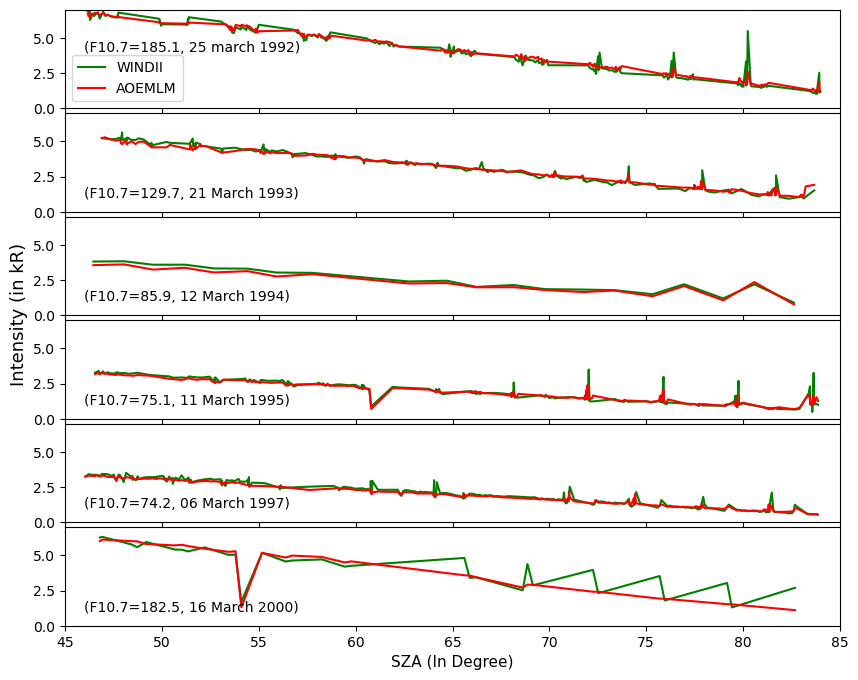

In [45]:
fig=plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.05)
fig.text(0.07, 0.5, 'Intensity (in kR)',fontsize=13, va='center', rotation='vertical')

plt.xlim(0,85)
plt.ylim(0,7)

plt.subplot(6,1,1)
plt.xlim(45,85)
plt.ylim(0,7)
plt.xticks(fontsize=0)
plt.plot(dfn92['SZA'],dfn92['WINDII'],c='g',label='WINDII')
plt.plot(dfn92['SZA'],dfn92['PRD'],c='r',label='AOEMLM')
plt.text(46,4,'(F10.7=185.1, 25 march 1992)')
plt.legend()

plt.subplot(6,1,2)
plt.xlim(45,85)
plt.ylim(0,7)
plt.xticks(fontsize=0)
plt.plot(dfn93['SZA'],dfn93['WINDII'],c='g',label='WINDII, 1993')
plt.plot(dfn93['SZA'],dfn93['PRD'],c='r',label='AOEMLM, 1993')
plt.text(46,1,'(F10.7=129.7, 21 March 1993)')
#plt.legend()

plt.subplot(6,1,3)
plt.xlim(45,85)
plt.ylim(0,7)
plt.xticks(fontsize=0)
plt.plot(dfn94['SZA'],dfn94['WINDII'],c='g',label='WINDII, 1994')
plt.plot(dfn94['SZA'],dfn94['PRD'],c='r',label='AOEMLM, 1994')
plt.text(46,1,'(F10.7=85.9, 12 March 1994)')
#plt.legend()

plt.subplot(6,1,4)
plt.xlim(45,85)
plt.ylim(0,7)
plt.xticks(fontsize=0)
plt.plot(dfn95['SZA'],dfn95['WINDII'],c='g',label='WINDII, 1995')
plt.plot(dfn95['SZA'],dfn95['PRD'],c='r',label='AOEMLM, 1995')
plt.text(46,1,'(F10.7=75.1, 11 March 1995)')
#plt.legend()

plt.subplot(6,1,5)
plt.xlim(45,85)
plt.ylim(0,7)
plt.xticks(fontsize=0)
plt.plot(dfn97['SZA'],dfn97['WINDII'],c='g',label='WINDII, 1997')
plt.plot(dfn97['SZA'],dfn97['PRD'],c='r',label='AOEMLM, 1997')
plt.text(46,1,'(F10.7=74.2, 06 March 1997)')
#plt.legend()

plt.subplot(6,1,6)
plt.xlabel('SZA (In Degree)',fontsize=11)
plt.xlim(45,85)
plt.ylim(0,7)
plt.plot(dfn20['SZA'],dfn20['WINDII'],c='g',label='WINDII, 2000')
plt.plot(dfn20['SZA'],dfn20['PRD'],c='r',label='AOEMLM, 2000')

plt.text(46,1,'(F10.7=182.5, 16 March 2000)')
#plt.legend()

#plt.savefig('Intensity_Daily_SZA_45_to_85.png',dpi=300, bbox_inches='tight')
#plt.savefig('Intensity_Daily_SZA_45_to_85.eps',dpi=300, bbox_inches='tight')

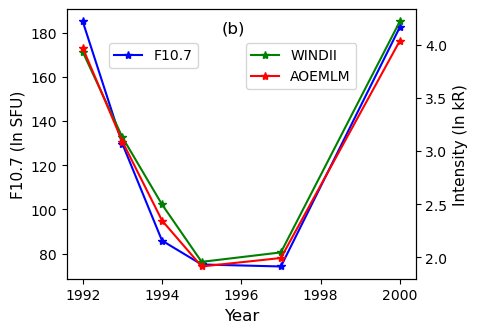

In [46]:
year=[1992,1993, 1994, 1995, 1997, 2000]
f107=[185.1,129.7,85.9,75.1,74.2,182.5]


windii= [dfn92['WINDII'].mean(), dfn93['WINDII'].mean(), dfn94['WINDII'].mean(), dfn95['WINDII'].mean(), 
         dfn97['WINDII'].mean(), dfn20['WINDII'].mean()]
aoemlm= [dfn92['PRD'].mean(), dfn93['PRD'].mean(), dfn94['PRD'].mean(), dfn95['PRD'].mean(), 
         dfn97['PRD'].mean(), dfn20['PRD'].mean()]
    
plt.figure(figsize=(4.5,3.5))
plt.xlabel('Year',fontsize=12)
plt.ylabel('F10.7 (In SFU)',fontsize=11)
plt.plot(year,f107,c='b',marker='*',label='F10.7')
plt.legend(loc='upper left', bbox_to_anchor=(0.1, 0.90))
plt.text(1995.5,180,'(b)',fontsize=12)

plt.twinx()
plt.ylabel('Intensity (In kR)',fontsize=11)
plt.plot(year,windii,c='g',marker='*',label='WINDII')
plt.plot(year,aoemlm,c='r',marker='*',label='AOEMLM')
plt.legend(loc='upper right', bbox_to_anchor=(0.85, 0.90))
#plt.savefig('Intensity_F107_correlation.png',dpi=300, bbox_inches='tight')
#plt.savefig('Intensity_F107_correlation.eps',dpi=300, bbox_inches='tight')

In [47]:
# MIGHTI daily averaged intensity for 2020
dfm=pd.read_csv('MIGHTI_OMNI_data.csv')
glo=pd.read_csv('GLOW_WINDII_daily_averaged_Intensity_2020.csv')

In [48]:
li=[]
for i in range(2020,2021):
    dt=dfm[(dfm['year']==i)]['DOY'].unique()
    
    for j in range(len(dt)):
        dfa0=dfm[(dfm['year']==i) & (dfm['DOY']==dt[j])]
        utx=dfa0['UT'].unique()
        lim=[]
        for k in range(len(utx)):
            dfa=dfa0[(dfa0['UT']==utx[k])].sort_values(by='altitude')

            input_test= dfa[['LT','F10.7','L_alpha','S_spot','SZA','latitude','longitude','altitude']]
            mver=model.predict(input_test)
            dfa.insert(21,'mVER',mver)

            x = dfa['VER']
            pre_x= dfa['mVER']
            y= dfa['altitude']

            wnd=scipy.integrate.trapz(x,y*100000)/10**9 # in kilo Rayleigh
            prd=scipy.integrate.trapz(pre_x,y*100000)/10**9 # in kilo Rayleigh

            dfn=pd.DataFrame(dfa.mean()).T
            dfn.insert(21,'MIGHTI',wnd)
            dfn.insert(22,'PRD',prd)
            lim.append(dfn)
        dfd=pd.concat(lim)
        dfn1=pd.DataFrame(dfd.mean()).T
        li.append(dfn1)

dfnl20=pd.concat(li)

Mean deviation (GLOW) = 0.8892660855565435
Mean deviation (AOEMLM) = 0.6610976780575285


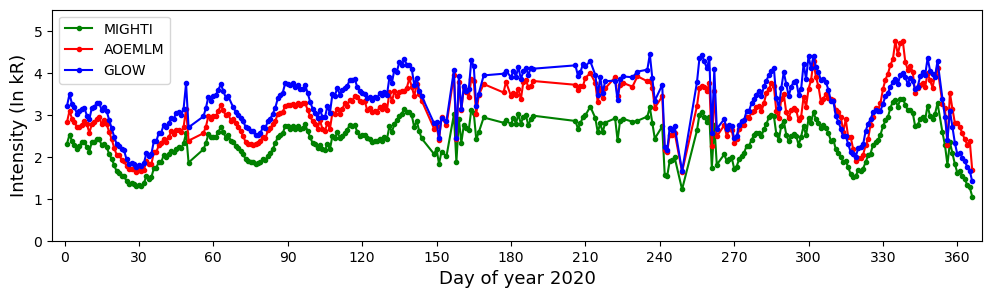

In [49]:
plt.figure(figsize=(12,3))

plt.xlabel('Day of year 2020',fontsize=13)
plt.ylabel('Intensity (In kR)',fontsize=13)
xtk=np.arange(0,370,30)
plt.xticks(xtk)
plt.xlim(-5,370)
plt.ylim(0,5.5)
x=dfnl20['DOY']
x0=glo['DOY']
plt.plot(x,dfnl20['MIGHTI'],c='g',label='MIGHTI',marker='o',markersize=3)
plt.plot(x,dfnl20['PRD'],c='r',label='AOEMLM',marker='o',markersize=3)
plt.plot(x0,glo['GLOW'],c='b',label='GLOW',marker='o',markersize=3)
plt.legend(loc='upper left')

diffr_g=(glo['GLOW']- glo['MIGHTI'])
mean_deviation_GLOW=sum(diffr_g)/len(diffr_g)

diffr_m=(dfnl20['PRD']- dfnl20['MIGHTI'])
mean_deviation_m=sum(diffr_m)/len(diffr_m)

print('Mean deviation (GLOW) =',mean_deviation_GLOW)
print('Mean deviation (AOEMLM) =',mean_deviation_m)

plt.savefig('Daily_average_VER_2020_without_SD.png', dpi=300,bbox_inches='tight')
#plt.savefig('Daily_average_VER_2020_without_SD.eps', dpi=300,bbox_inches='tight')

In [50]:
#Photometer Hydrabad verification

Text(5.9, 15, '(d) 09 August 2024')

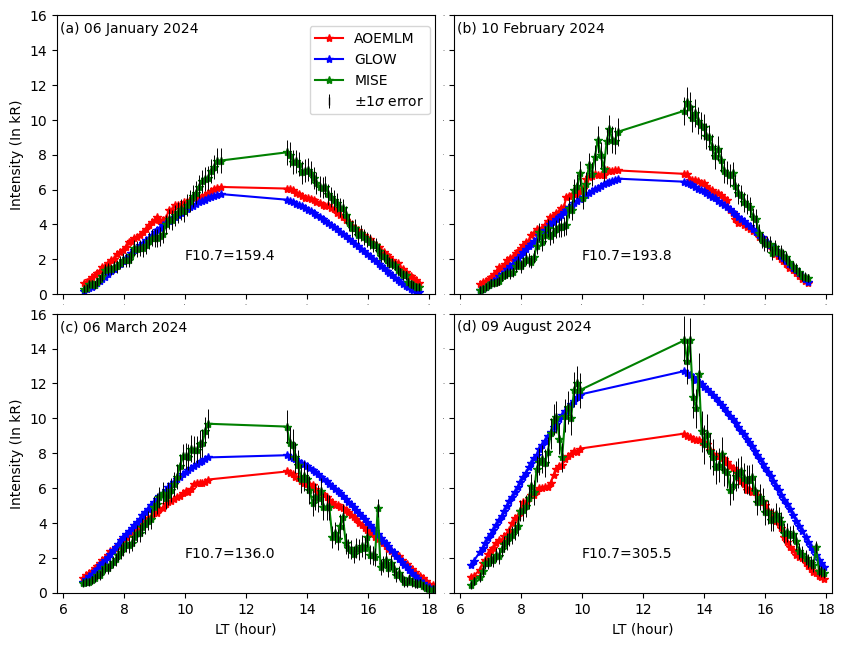

In [51]:
fdf=pd.read_csv('MISE_GLOW_AOEMLM_Intensity_2024.csv')

plt.figure(figsize=(10,7.5))
plt.subplots_adjust(wspace=0.05,hspace=0.07)

plt.subplot(2,2,1)
fd1=fdf[(fdf['DOY']==6)]
#plt.xlabel('LT (hour)')
plt.xticks(fontsize=0)
plt.ylabel('Intensity (In kR)')
plt.plot(fd1['LT'],fd1['m_Intg'],c='r',label='AOEMLM',marker='*')
plt.plot(fd1['LT'],fd1['Glo_Intg'],c='b',label='GLOW',marker='*')
plt.plot(fd1['LT'],fd1['p_Intg'],c='g',label='MISE',marker='*')
y_error = [fd1['Error'], fd1['Error']]
plt.errorbar(fd1['LT'], fd1['p_Intg'], yerr=y_error, fmt="|", color="black",lw=0.7,label='$\pm1\sigma$ error')
plt.text(10,2,'F10.7=159.4')
plt.xlim(5.8,18.2)
plt.ylim(0,16)
plt.text(5.9,15,'(a) 06 January 2024')
plt.legend( bbox_to_anchor=(0.65, 0.62))

plt.subplot(2,2,2)
fd2=fdf[(fdf['DOY']==41)]
#plt.ylabel('Intensity (In kR)')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.plot(fd2['LT'],fd2['m_Intg'],c='r',marker='*')
plt.plot(fd2['LT'],fd2['Glo_Intg'],c='b',marker='*')
plt.plot(fd2['LT'],fd2['p_Intg'],c='g',marker='*')
y_error = [fd2['Error'], fd2['Error']]
plt.errorbar(fd2['LT'], fd2['p_Intg'], yerr=y_error, fmt="|", color="black",lw=0.7)
plt.text(10,2,'F10.7=193.8')
plt.xlim(5.8,18.2)
plt.ylim(0,16)
plt.text(5.9,15,'(b) 10 February 2024')

plt.subplot(2,2,3)
fd3=fdf[(fdf['DOY']==66)]
plt.xlabel('LT (hour)')
plt.ylabel('Intensity (In kR)')
plt.plot(fd3['LT'],fd3['m_Intg'],c='r',marker='*')
plt.plot(fd3['LT'],fd3['Glo_Intg'],c='b',marker='*')
plt.plot(fd3['LT'],fd3['p_Intg'],c='g',marker='*')
y_error = [fd3['Error'], fd3['Error']]
plt.errorbar(fd3['LT'], fd3['p_Intg'], yerr=y_error, fmt="|", color="black",lw=0.7)
plt.text(10,2,'F10.7=136.0')
plt.xlim(5.8,18.2)
plt.ylim(0,16)
plt.text(5.9,15,'(c) 06 March 2024')

plt.subplot(2,2,4)
fd4=fdf[(fdf['DOY']==222)]
plt.xlabel('LT (hour)')
#plt.ylabel('Intensity (In kR)')
plt.yticks(fontsize=0)
plt.plot(fd4['LT'],fd4['m_Intg'],c='r',marker='*')
plt.plot(fd4['LT'],fd4['Glo_Intg'],c='b',marker='*')
plt.plot(fd4['LT'],fd4['p_Intg'],c='g',marker='*')
y_error = [fd4['Error'], fd4['Error']]
plt.errorbar(fd4['LT'], fd4['p_Intg'], yerr=y_error, fmt="|", color="black",lw=0.7)
plt.text(10,2,'F10.7=305.5')
plt.xlim(5.8,18.2)
plt.ylim(0,16)
plt.text(5.9,15,'(d) 09 August 2024')

#plt.savefig('Green_line_2024.png',dpi=400,bbox_inches='tight')
#plt.savefig('Green_line_2024.eps',dpi=400,bbox_inches='tight')